Load all the modules


In [4]:
import os

import torch
import torchaudio
import torch.nn as nn
from torch.utils import data

import ast
import librosa
import pandas as pd
import numpy as np

import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

Function to load the FMA Small files from where we can the file ids.

In [ ]:
def load_fma_csv(filepath):
    """
    Loads the CSV data
    https://github.com/mdeff/fma/blob/master/utils.py a part of the 'load' function
    """
    tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

    COLUMNS = [
        ("track", "tags"),
        ("album", "tags"),
        ("artist", "tags"),
        ("track", "genres"),
        ("track", "genres_all"),
    ]
    for column in COLUMNS:
        tracks[column] = tracks[column].map(ast.literal_eval)

    COLUMNS = [
        ("track", "date_created"),
        ("track", "date_recorded"),
        ("album", "date_created"),
        ("album", "date_released"),
        ("artist", "date_created"),
        ("artist", "active_year_begin"),
        ("artist", "active_year_end"),
    ]
    for column in COLUMNS:
        tracks[column] = pd.to_datetime(tracks[column])

    SUBSETS = ("small", "medium", "large")
    try:
        tracks["set", "subset"] = tracks["set", "subset"].astype(
            "category", categories=SUBSETS, ordered=True
        )
    except (ValueError, TypeError):
        # the categories and ordered arguments were removed in pandas 0.25
        tracks["set", "subset"] = tracks["set", "subset"].astype(
            pd.CategoricalDtype(categories=SUBSETS, ordered=True)
        )

    COLUMNS = [
        ("track", "genre_top"),
        ("track", "license"),
        ("album", "type"),
        ("album", "information"),
        ("artist", "bio"),
    ]
    for column in COLUMNS:
        tracks[column] = tracks[column].astype("category")

    return tracks

Load the stuff

In [ ]:
tracks = load_fma_csv("fma_metadata/tracks.csv")

Select only the small dataset data

In [ ]:
small = tracks["set", "subset"] <= "small"

train = tracks["set", "split"] == "training"
val = tracks["set", "split"] == "validation"
test = tracks["set", "split"] == "test"

y_train = tracks.loc[small & train, ("track", "genre_top")]
y_val = tracks.loc[small & val, ("track", "genre_top")]
y_test = tracks.loc[small & test, ("track", "genre_top")]

print(
    "{} training examples, {} validation examples, {} testing examples".format(
        y_train.size, y_val.size, y_test.size
    )
)

6400 training examples, 800 validation examples, 800 testing examples


One-hot encode all the genre labels

In [ ]:
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_val = enc.transform(y_val)
y_test = enc.fit_transform(y_test)

print(np.unique(y_train).size)
print(np.unique(y_val).size)
print(np.unique(y_test).size)

8
8
8


Lets load all the waveforms!

In [ ]:
# Get all the files

train &= small
tmp = train.values
tmpi = train.index.values
train_files = [tmpi[x] for x in range(len(tmp)) if tmp[x]]

val &= small
tmp = val.values
tmpi = val.index.values
val_files = [tmpi[x] for x in range(len(tmp)) if tmp[x]]

test &= small
tmp = test.values
tmpi = test.index.values
test_files = [tmpi[x] for x in range(len(tmp)) if tmp[x]]

print(len(train_files), len(val_files), len(test_files))

6400 800 800


In [ ]:
import warnings

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fs = 22050
melspec = torchaudio.transforms.MelSpectrogram(sample_rate=fs,
                                               n_fft=1024,
                                               f_min=0.0,
                                               f_max=fs / 2,
                                               n_mels=128
                                               ).to(device)

amp_to_db = torchaudio.transforms.AmplitudeToDB()

def load_specs(file_list):
    """"""
    specs = []
    chromas = []
    bad_indices = []

    for i in tqdm.tqdm(range(len(file_list)), ncols=0):
        ind = file_list[i]
        ind = int(ind)
        folder = str(ind // 1000).zfill(3)

        try:
            # Some files WILL raise an ugly warning, used to get a clean output
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')

                # Automatically resamples to 22050 and converts to mono :)
                wav, _ = librosa.load('fma_small/' + folder + '/' + str(ind).zfill(6) + '.mp3')

        except:
            # If we cannot open the file add to list for removal and move on
            bad_indices.append(i)
            continue

        try:
            # We want the files to be uniform, cut the last ~2k samples to force length, if a song doesn't have that many samples remove it from the data
            if len(wav) < 658000:
                raise

            # Lets move the tensor to cpu to not eat all the available vram
            # Also lets save the compute and save spectogram to save ram and later computing takes around ~9 GB of ram to keep all in memory
            # If you do not have this much available, load the waves when creating a batch and compute the specs in the forward of the net
            wav = wav[:658000]

            wav = torch.tensor(wav).to(device)
            specs.append(amp_to_db(melspec(wav)).to('cpu'))

        except:
            bad_indices.append(i)

    return specs, bad_indices

# Load all the specs and save to tensors
train_specs, bad_train_indices = load_specs(train_files)
train_specs = torch.stack(tuple(train_specs))

test_specs, bad_test_indices = load_specs(test_files)
test_specs = torch.stack(tuple(test_specs))

val_specs, bad_val_indices = load_specs(val_files)
val_specs = torch.stack(tuple(val_specs))

100% 6400/6400 [05:51<00:00, 18.22it/s]
100% 800/800 [00:47<00:00, 16.79it/s]
100% 800/800 [00:48<00:00, 16.53it/s]


Lets check the shape of the created spectogram tensors

In [ ]:
print(train_specs.shape)
print(test_specs.shape)
print(val_specs.shape)

torch.Size([6394, 128, 1286])
torch.Size([800, 128, 1286])
torch.Size([800, 128, 1286])


Looks good, there is supposed to be 6 tracks in FMA small that are shorter than 30 seconds. Lets remove them from the labels aswell.

In [ ]:
y_train = [y_train[x] for x in range(len(y_train)) if x not in bad_train_indices]
y_test = [y_test[x] for x in range(len(y_test)) if x not in bad_test_indices]
y_val = [y_val[x] for x in range(len(y_val)) if x not in bad_val_indices]

print(len(y_train))
print(len(y_test))
print(len(y_val))

6394
800
800


Lets convert the labels to tensors for pytorch

In [ ]:
y_train = torch.tensor(y_train, dtype = torch.long)
y_val = torch.tensor(y_val, dtype = torch.long)
y_test = torch.tensor(y_test, dtype = torch.long)

Lets save the tensors so we dont need to recompute everytime we restart!

In [ ]:
torch.save(train_specs, 'CNN/train_specs.pt')
torch.save(val_specs, 'CNN/val_specs.pt')
torch.save(test_specs, 'CNN/test_specs.pt')

torch.save(y_train, 'CNN/y_train.pt')
torch.save(y_val, 'CNN/y_val.pt')
torch.save(y_test, 'CNN/y_test.pt')

Load the pre-computed data

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

specs = torch.cat((torch.load('CNN/train_specs.pt'),
                   torch.load('CNN/val_specs.pt'),
                   torch.load('CNN/test_specs.pt')
                   ))[:, :, :-6] # Remove last 6 elements to get the spectogram divisible by 8

y = torch.cat((torch.load('CNN/y_train.pt'),
               torch.load('CNN/y_val.pt'),
               torch.load('CNN/y_test.pt')
               ))

print(specs.shape)
print(y.shape)

Now lets build the Dataloader

In [5]:
class FMADataset(data.Dataset):
    def __init__(self, specs, labels):
        self.specs = specs
        self.labels = labels

    def __len__(self):
        return len(self.specs)

    def __getitem__(self, idx):
        return self.specs[idx], self.labels[idx]

def get_DataLoader(dataset,
                   split = 'train',
                   n_workers = 0,
                   batch_size = 32
                   ):
    shuffle = split == 'train'
    dataloader = data.DataLoader(dataset = dataset,
                                 batch_size = batch_size,
                                 shuffle = shuffle,
                                 drop_last = False,
                                 num_workers = n_workers
                                 )
    return dataloader

train_dset = FMADataset(specs, y)

train_dset, val_dset, test_dset = torch.utils.data.random_split(train_dset, [0.7, 0.2, 0.1])

train_loader = get_DataLoader(train_dset)
iter_train_loader = iter(train_loader)
train_spec, train_label = next(iter_train_loader)

test_loader = get_DataLoader(test_dset, split='test')
valid_loader = get_DataLoader(val_dset, split='val')
iter_test_loader = iter(test_loader)
test_spec, test_label = next(iter_test_loader)

print(len(train_loader), len(valid_loader), len(test_loader))
print('training data shape: %s' % str(train_spec.shape))
print('validation/test data shape: %s' % str(test_spec.shape))
print(train_label)

del train_label, test_label

175 50 25
training data shape: torch.Size([32, 128, 1280])
validation/test data shape: torch.Size([32, 128, 1280])
tensor([7, 1, 5, 2, 6, 0, 3, 5, 3, 2, 2, 2, 2, 7, 5, 1, 0, 5, 7, 4, 7, 4, 5, 7,
        1, 3, 4, 6, 1, 4, 4, 6])


Lets make 2-D Conv baseline

In [28]:
class Conv2d_layer(nn.Module):
    def __init__(self, out_c, kernel_size, pooling, dropout=0.1):
        super(Conv2d_layer, self).__init__()
        self.layer = nn.Sequential(
            nn.LazyConv2d(out_c, kernel_size, padding = kernel_size // 2), #padding = 'valid'
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.MaxPool2d(pooling, stride = pooling),
            nn.Dropout(dropout)
        )

    def forward(self, data):
        return self.layer(data)

class CNN(nn.Module):
    def __init__(self, n_chan, kernel_size, n_genres):
        super(CNN, self).__init__()

        self.net = nn.Sequential(
            nn.BatchNorm2d(1),
            Conv2d_layer(n_chan, kernel_size, pooling=(2, 3), dropout=0.2),
            Conv2d_layer(n_chan, kernel_size, pooling=(3, 4), dropout=0.2),
            Conv2d_layer(2 * n_chan, kernel_size, pooling=(2, 5), dropout=0.2),
            Conv2d_layer(2 * n_chan, kernel_size, pooling=(3, 3), dropout=0.2),
            Conv2d_layer(4 * n_chan, kernel_size, pooling=(3, 4), dropout=0.2),
            nn.Flatten(),
            nn.LazyLinear(4 * n_chan),
            nn.BatchNorm1d(4 * n_chan),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.LazyLinear(n_genres)
        )


    def forward(self, spec):
        spec = spec.unsqueeze(1)
        return self.net(spec)

In [29]:
cnn = CNN(n_chan = 16, kernel_size = 3, n_genres=8).to(device)

# Send a sample to the net init all the lazy layers
cnn(train_spec.to(device))

n_epochs = 80
lr = 0.001

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(cnn.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim)

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    losses = []

    for specs, labels in tqdm.tqdm(train_loader):
        out = cnn(specs.to(device))
        loss = loss_fn(out, labels.to(device))

        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())

    train_loss = np.mean(losses)
    train_losses.append(train_loss)
    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch + 1, n_epochs, train_loss))

    losses = []
    y_true = []
    y_pred = []
    for specs, labels in tqdm.tqdm(valid_loader):
        with torch.no_grad():
            logits = cnn(specs.to(device))

        loss = loss_fn(logits, labels.to(device))
        losses.append(loss.item())
        _, pred = torch.max(logits.data, 1)

        y_true.extend(labels.tolist())
        y_pred.extend(pred.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    val_loss = np.mean(losses)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f, Current LR: %0.8f' % (epoch+1, n_epochs, val_loss, accuracy, scheduler.get_last_lr()[-1]))

    if np.argmin(val_losses) == epoch:
        print('New best model found!')
        torch.save(cnn.state_dict(), 'best_model_lin.ckpt')

torch.save(cnn.state_dict(), 'final_model_lin.ckpt')

100%|██████████| 175/175 [00:15<00:00, 11.54it/s]


Epoch: [1/80], Train loss: 1.8914


100%|██████████| 50/50 [00:01<00:00, 29.67it/s]


Epoch: [1/80], Valid loss: 1.7834, Valid accuracy: 0.3215, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 11.88it/s]


Epoch: [2/80], Train loss: 1.7201


100%|██████████| 50/50 [00:01<00:00, 29.33it/s]


Epoch: [2/80], Valid loss: 1.6767, Valid accuracy: 0.3777, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 12.05it/s]


Epoch: [3/80], Train loss: 1.6403


100%|██████████| 50/50 [00:01<00:00, 30.82it/s]


Epoch: [3/80], Valid loss: 1.6202, Valid accuracy: 0.4109, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 12.08it/s]


Epoch: [4/80], Train loss: 1.5755


100%|██████████| 50/50 [00:01<00:00, 31.18it/s]


Epoch: [4/80], Valid loss: 1.5810, Valid accuracy: 0.4340, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:15<00:00, 11.41it/s]


Epoch: [5/80], Train loss: 1.5354


100%|██████████| 50/50 [00:01<00:00, 30.49it/s]


Epoch: [5/80], Valid loss: 1.5766, Valid accuracy: 0.4309, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 11.98it/s]


Epoch: [6/80], Train loss: 1.5140


100%|██████████| 50/50 [00:01<00:00, 30.92it/s]


Epoch: [6/80], Valid loss: 1.5235, Valid accuracy: 0.4647, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 11.98it/s]


Epoch: [7/80], Train loss: 1.4648


100%|██████████| 50/50 [00:01<00:00, 30.70it/s]


Epoch: [7/80], Valid loss: 1.5231, Valid accuracy: 0.4640, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 12.02it/s]


Epoch: [8/80], Train loss: 1.4519


100%|██████████| 50/50 [00:01<00:00, 29.41it/s]


Epoch: [8/80], Valid loss: 1.5004, Valid accuracy: 0.4640, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 12.06it/s]


Epoch: [9/80], Train loss: 1.4229


100%|██████████| 50/50 [00:01<00:00, 29.38it/s]


Epoch: [9/80], Valid loss: 1.4773, Valid accuracy: 0.4853, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 12.03it/s]


Epoch: [10/80], Train loss: 1.4039


100%|██████████| 50/50 [00:01<00:00, 31.21it/s]


Epoch: [10/80], Valid loss: 1.4872, Valid accuracy: 0.4803, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.04it/s]


Epoch: [11/80], Train loss: 1.3988


100%|██████████| 50/50 [00:01<00:00, 30.75it/s]


Epoch: [11/80], Valid loss: 1.4452, Valid accuracy: 0.4953, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [12/80], Train loss: 1.3829


100%|██████████| 50/50 [00:01<00:00, 31.08it/s]


Epoch: [12/80], Valid loss: 1.4721, Valid accuracy: 0.4809, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.01it/s]


Epoch: [13/80], Train loss: 1.3619


100%|██████████| 50/50 [00:01<00:00, 31.06it/s]


Epoch: [13/80], Valid loss: 1.4336, Valid accuracy: 0.5066, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 12.01it/s]


Epoch: [14/80], Train loss: 1.3569


100%|██████████| 50/50 [00:01<00:00, 31.23it/s]


Epoch: [14/80], Valid loss: 1.4237, Valid accuracy: 0.5166, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 12.03it/s]


Epoch: [15/80], Train loss: 1.3387


100%|██████████| 50/50 [00:01<00:00, 29.73it/s]


Epoch: [15/80], Valid loss: 1.4424, Valid accuracy: 0.5034, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.02it/s]


Epoch: [16/80], Train loss: 1.3382


100%|██████████| 50/50 [00:01<00:00, 29.36it/s]


Epoch: [16/80], Valid loss: 1.4154, Valid accuracy: 0.5235, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 11.93it/s]


Epoch: [17/80], Train loss: 1.3140


100%|██████████| 50/50 [00:01<00:00, 30.15it/s]


Epoch: [17/80], Valid loss: 1.4025, Valid accuracy: 0.5153, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 12.02it/s]


Epoch: [18/80], Train loss: 1.3086


100%|██████████| 50/50 [00:01<00:00, 31.34it/s]


Epoch: [18/80], Valid loss: 1.4289, Valid accuracy: 0.5041, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.03it/s]


Epoch: [19/80], Train loss: 1.3124


100%|██████████| 50/50 [00:01<00:00, 30.98it/s]


Epoch: [19/80], Valid loss: 1.4060, Valid accuracy: 0.5172, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.02it/s]


Epoch: [20/80], Train loss: 1.3034


100%|██████████| 50/50 [00:01<00:00, 31.14it/s]


Epoch: [20/80], Valid loss: 1.4034, Valid accuracy: 0.5128, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.01it/s]


Epoch: [21/80], Train loss: 1.2667


100%|██████████| 50/50 [00:01<00:00, 31.04it/s]


Epoch: [21/80], Valid loss: 1.3655, Valid accuracy: 0.5247, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 12.01it/s]


Epoch: [22/80], Train loss: 1.2852


100%|██████████| 50/50 [00:01<00:00, 31.08it/s]


Epoch: [22/80], Valid loss: 1.3771, Valid accuracy: 0.5366, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 11.99it/s]


Epoch: [23/80], Train loss: 1.2633


100%|██████████| 50/50 [00:01<00:00, 30.42it/s]


Epoch: [23/80], Valid loss: 1.3865, Valid accuracy: 0.5316, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 11.99it/s]


Epoch: [24/80], Train loss: 1.2726


100%|██████████| 50/50 [00:01<00:00, 29.40it/s]


Epoch: [24/80], Valid loss: 1.3831, Valid accuracy: 0.5353, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.01it/s]


Epoch: [25/80], Train loss: 1.2725


100%|██████████| 50/50 [00:01<00:00, 28.94it/s]


Epoch: [25/80], Valid loss: 1.3908, Valid accuracy: 0.5291, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.05it/s]


Epoch: [26/80], Train loss: 1.2563


100%|██████████| 50/50 [00:01<00:00, 30.76it/s]


Epoch: [26/80], Valid loss: 1.3849, Valid accuracy: 0.5191, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [27/80], Train loss: 1.2575


100%|██████████| 50/50 [00:01<00:00, 29.50it/s]


Epoch: [27/80], Valid loss: 1.3945, Valid accuracy: 0.5184, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.03it/s]


Epoch: [28/80], Train loss: 1.2340


100%|██████████| 50/50 [00:01<00:00, 31.40it/s]


Epoch: [28/80], Valid loss: 1.3723, Valid accuracy: 0.5341, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [29/80], Train loss: 1.2352


100%|██████████| 50/50 [00:01<00:00, 29.69it/s]


Epoch: [29/80], Valid loss: 1.3744, Valid accuracy: 0.5322, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.01it/s]


Epoch: [30/80], Train loss: 1.2331


100%|██████████| 50/50 [00:01<00:00, 30.48it/s]


Epoch: [30/80], Valid loss: 1.3530, Valid accuracy: 0.5391, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 12.04it/s]


Epoch: [31/80], Train loss: 1.2313


100%|██████████| 50/50 [00:01<00:00, 29.42it/s]


Epoch: [31/80], Valid loss: 1.3668, Valid accuracy: 0.5385, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.01it/s]


Epoch: [32/80], Train loss: 1.2074


100%|██████████| 50/50 [00:01<00:00, 28.94it/s]


Epoch: [32/80], Valid loss: 1.3843, Valid accuracy: 0.5328, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [33/80], Train loss: 1.2326


100%|██████████| 50/50 [00:01<00:00, 30.90it/s]


Epoch: [33/80], Valid loss: 1.3678, Valid accuracy: 0.5366, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.04it/s]


Epoch: [34/80], Train loss: 1.2063


100%|██████████| 50/50 [00:01<00:00, 30.85it/s]


Epoch: [34/80], Valid loss: 1.3812, Valid accuracy: 0.5353, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.02it/s]


Epoch: [35/80], Train loss: 1.2101


100%|██████████| 50/50 [00:01<00:00, 31.02it/s]


Epoch: [35/80], Valid loss: 1.3617, Valid accuracy: 0.5222, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.02it/s]


Epoch: [36/80], Train loss: 1.2036


100%|██████████| 50/50 [00:01<00:00, 30.78it/s]


Epoch: [36/80], Valid loss: 1.3860, Valid accuracy: 0.5360, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.03it/s]


Epoch: [37/80], Train loss: 1.1982


100%|██████████| 50/50 [00:01<00:00, 29.87it/s]


Epoch: [37/80], Valid loss: 1.3640, Valid accuracy: 0.5366, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 11.89it/s]


Epoch: [38/80], Train loss: 1.1905


100%|██████████| 50/50 [00:01<00:00, 30.46it/s]


Epoch: [38/80], Valid loss: 1.3768, Valid accuracy: 0.5328, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [39/80], Train loss: 1.1845


100%|██████████| 50/50 [00:01<00:00, 29.84it/s]


Epoch: [39/80], Valid loss: 1.3672, Valid accuracy: 0.5422, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 11.99it/s]


Epoch: [40/80], Train loss: 1.1729


100%|██████████| 50/50 [00:01<00:00, 29.81it/s]


Epoch: [40/80], Valid loss: 1.3496, Valid accuracy: 0.5460, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 11.99it/s]


Epoch: [41/80], Train loss: 1.1718


100%|██████████| 50/50 [00:01<00:00, 29.40it/s]


Epoch: [41/80], Valid loss: 1.3601, Valid accuracy: 0.5391, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 11.99it/s]


Epoch: [42/80], Train loss: 1.1626


100%|██████████| 50/50 [00:01<00:00, 31.18it/s]


Epoch: [42/80], Valid loss: 1.3929, Valid accuracy: 0.5247, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.01it/s]


Epoch: [43/80], Train loss: 1.1711


100%|██████████| 50/50 [00:01<00:00, 30.74it/s]


Epoch: [43/80], Valid loss: 1.3842, Valid accuracy: 0.5410, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [44/80], Train loss: 1.1646


100%|██████████| 50/50 [00:01<00:00, 31.17it/s]


Epoch: [44/80], Valid loss: 1.3516, Valid accuracy: 0.5478, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [45/80], Train loss: 1.1443


100%|██████████| 50/50 [00:01<00:00, 31.14it/s]


Epoch: [45/80], Valid loss: 1.3696, Valid accuracy: 0.5472, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 11.99it/s]


Epoch: [46/80], Train loss: 1.1488


100%|██████████| 50/50 [00:01<00:00, 31.26it/s]


Epoch: [46/80], Valid loss: 1.3949, Valid accuracy: 0.5278, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [47/80], Train loss: 1.1481


100%|██████████| 50/50 [00:01<00:00, 30.09it/s]


Epoch: [47/80], Valid loss: 1.3687, Valid accuracy: 0.5466, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.03it/s]


Epoch: [48/80], Train loss: 1.1409


100%|██████████| 50/50 [00:01<00:00, 29.28it/s]


Epoch: [48/80], Valid loss: 1.3639, Valid accuracy: 0.5353, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.02it/s]


Epoch: [49/80], Train loss: 1.1479


100%|██████████| 50/50 [00:01<00:00, 29.27it/s]


Epoch: [49/80], Valid loss: 1.3860, Valid accuracy: 0.5372, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [50/80], Train loss: 1.1401


100%|██████████| 50/50 [00:01<00:00, 31.19it/s]


Epoch: [50/80], Valid loss: 1.3481, Valid accuracy: 0.5441, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [51/80], Train loss: 1.1271


100%|██████████| 50/50 [00:01<00:00, 31.24it/s]


Epoch: [51/80], Valid loss: 1.3580, Valid accuracy: 0.5510, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.01it/s]


Epoch: [52/80], Train loss: 1.1326


100%|██████████| 50/50 [00:01<00:00, 29.81it/s]


Epoch: [52/80], Valid loss: 1.3743, Valid accuracy: 0.5378, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.02it/s]


Epoch: [53/80], Train loss: 1.1184


100%|██████████| 50/50 [00:01<00:00, 30.75it/s]


Epoch: [53/80], Valid loss: 1.3962, Valid accuracy: 0.5347, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [54/80], Train loss: 1.1246


100%|██████████| 50/50 [00:01<00:00, 30.98it/s]


Epoch: [54/80], Valid loss: 1.3297, Valid accuracy: 0.5460, Current LR: 0.00100000
New best model found!


100%|██████████| 175/175 [00:14<00:00, 12.02it/s]


Epoch: [55/80], Train loss: 1.1138


100%|██████████| 50/50 [00:01<00:00, 30.65it/s]


Epoch: [55/80], Valid loss: 1.3690, Valid accuracy: 0.5347, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [56/80], Train loss: 1.1240


100%|██████████| 50/50 [00:01<00:00, 29.59it/s]


Epoch: [56/80], Valid loss: 1.3765, Valid accuracy: 0.5447, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.02it/s]


Epoch: [57/80], Train loss: 1.1279


100%|██████████| 50/50 [00:01<00:00, 29.26it/s]


Epoch: [57/80], Valid loss: 1.3911, Valid accuracy: 0.5322, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 11.90it/s]


Epoch: [58/80], Train loss: 1.1207


100%|██████████| 50/50 [00:01<00:00, 30.66it/s]


Epoch: [58/80], Valid loss: 1.3863, Valid accuracy: 0.5447, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.01it/s]


Epoch: [59/80], Train loss: 1.1014


100%|██████████| 50/50 [00:01<00:00, 31.12it/s]


Epoch: [59/80], Valid loss: 1.4046, Valid accuracy: 0.5385, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.01it/s]


Epoch: [60/80], Train loss: 1.0978


100%|██████████| 50/50 [00:01<00:00, 30.78it/s]


Epoch: [60/80], Valid loss: 1.3626, Valid accuracy: 0.5403, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.01it/s]


Epoch: [61/80], Train loss: 1.1120


100%|██████████| 50/50 [00:01<00:00, 30.84it/s]


Epoch: [61/80], Valid loss: 1.3760, Valid accuracy: 0.5535, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [62/80], Train loss: 1.0890


100%|██████████| 50/50 [00:01<00:00, 31.07it/s]


Epoch: [62/80], Valid loss: 1.3846, Valid accuracy: 0.5491, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.01it/s]


Epoch: [63/80], Train loss: 1.0910


100%|██████████| 50/50 [00:01<00:00, 30.76it/s]


Epoch: [63/80], Valid loss: 1.3783, Valid accuracy: 0.5416, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [64/80], Train loss: 1.1047


100%|██████████| 50/50 [00:01<00:00, 29.38it/s]


Epoch: [64/80], Valid loss: 1.3971, Valid accuracy: 0.5422, Current LR: 0.00100000


100%|██████████| 175/175 [00:14<00:00, 11.97it/s]


Epoch: [65/80], Train loss: 1.0853


100%|██████████| 50/50 [00:01<00:00, 29.71it/s]


Epoch: [65/80], Valid loss: 1.3559, Valid accuracy: 0.5578, Current LR: 0.00010000


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [66/80], Train loss: 1.0459


100%|██████████| 50/50 [00:01<00:00, 31.29it/s]


Epoch: [66/80], Valid loss: 1.3350, Valid accuracy: 0.5497, Current LR: 0.00010000


100%|██████████| 175/175 [00:14<00:00, 12.05it/s]


Epoch: [67/80], Train loss: 1.0553


100%|██████████| 50/50 [00:01<00:00, 31.04it/s]


Epoch: [67/80], Valid loss: 1.3839, Valid accuracy: 0.5316, Current LR: 0.00010000


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [68/80], Train loss: 1.0499


100%|██████████| 50/50 [00:01<00:00, 31.10it/s]


Epoch: [68/80], Valid loss: 1.3764, Valid accuracy: 0.5310, Current LR: 0.00010000


100%|██████████| 175/175 [00:14<00:00, 12.02it/s]


Epoch: [69/80], Train loss: 1.0403


100%|██████████| 50/50 [00:01<00:00, 31.08it/s]


Epoch: [69/80], Valid loss: 1.3319, Valid accuracy: 0.5435, Current LR: 0.00010000


100%|██████████| 175/175 [00:14<00:00, 11.99it/s]


Epoch: [70/80], Train loss: 1.0417


100%|██████████| 50/50 [00:01<00:00, 31.18it/s]


Epoch: [70/80], Valid loss: 1.3981, Valid accuracy: 0.5316, Current LR: 0.00010000


100%|██████████| 175/175 [00:14<00:00, 12.03it/s]


Epoch: [71/80], Train loss: 1.0337


100%|██████████| 50/50 [00:01<00:00, 30.03it/s]


Epoch: [71/80], Valid loss: 1.3720, Valid accuracy: 0.5466, Current LR: 0.00010000


100%|██████████| 175/175 [00:14<00:00, 12.02it/s]


Epoch: [72/80], Train loss: 1.0384


100%|██████████| 50/50 [00:01<00:00, 29.28it/s]


Epoch: [72/80], Valid loss: 1.3441, Valid accuracy: 0.5560, Current LR: 0.00010000


100%|██████████| 175/175 [00:14<00:00, 12.04it/s]


Epoch: [73/80], Train loss: 1.0307


100%|██████████| 50/50 [00:01<00:00, 30.38it/s]


Epoch: [73/80], Valid loss: 1.3773, Valid accuracy: 0.5485, Current LR: 0.00010000


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [74/80], Train loss: 1.0282


100%|██████████| 50/50 [00:01<00:00, 31.11it/s]


Epoch: [74/80], Valid loss: 1.3784, Valid accuracy: 0.5428, Current LR: 0.00010000


100%|██████████| 175/175 [00:14<00:00, 12.00it/s]


Epoch: [75/80], Train loss: 1.0427


100%|██████████| 50/50 [00:01<00:00, 31.23it/s]


Epoch: [75/80], Valid loss: 1.3937, Valid accuracy: 0.5422, Current LR: 0.00010000


100%|██████████| 175/175 [00:14<00:00, 12.01it/s]


Epoch: [76/80], Train loss: 1.0324


100%|██████████| 50/50 [00:01<00:00, 31.18it/s]


Epoch: [76/80], Valid loss: 1.3587, Valid accuracy: 0.5435, Current LR: 0.00001000


100%|██████████| 175/175 [00:14<00:00, 12.05it/s]


Epoch: [77/80], Train loss: 1.0132


100%|██████████| 50/50 [00:01<00:00, 31.09it/s]


Epoch: [77/80], Valid loss: 1.3347, Valid accuracy: 0.5553, Current LR: 0.00001000


100%|██████████| 175/175 [00:14<00:00, 12.02it/s]


Epoch: [78/80], Train loss: 1.0157


100%|██████████| 50/50 [00:01<00:00, 31.12it/s]


Epoch: [78/80], Valid loss: 1.3539, Valid accuracy: 0.5472, Current LR: 0.00001000


100%|██████████| 175/175 [00:14<00:00, 11.92it/s]


Epoch: [79/80], Train loss: 1.0180


100%|██████████| 50/50 [00:01<00:00, 29.83it/s]


Epoch: [79/80], Valid loss: 1.3603, Valid accuracy: 0.5591, Current LR: 0.00001000


100%|██████████| 175/175 [00:14<00:00, 12.03it/s]


Epoch: [80/80], Train loss: 1.0270


100%|██████████| 50/50 [00:01<00:00, 29.15it/s]

Epoch: [80/80], Valid loss: 1.3589, Valid accuracy: 0.5597, Current LR: 0.00001000


Printing the data

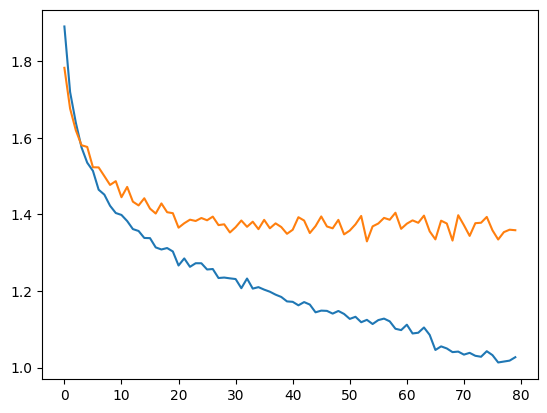

Accuracy: 0.6133


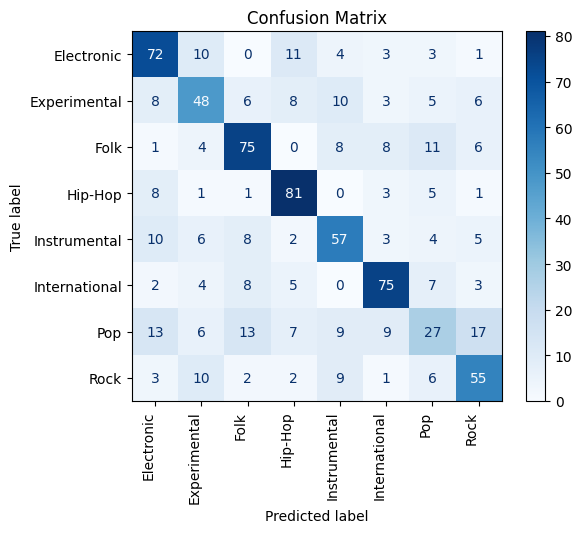

In [35]:
y_true = []
y_pred = []

for specs, labels in test_loader:
    with torch.no_grad():
        logits = cnn(specs.to(device))

    loss = loss_fn(logits, labels.to(device))
    losses.append(loss.item())
    _, pred = torch.max(logits.data, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(pred.tolist())

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

l = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
#sns.heatmap(cm, annot=True, xticklabels=l, yticklabels=l, cmap='YlGnBu', fmt='d')
print('Accuracy: %.4f' % accuracy)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=l)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90, ha='right')
plt.title("Confusion Matrix")
plt.show()

np.save('y_true_model_1.npy', np.array(y_true))
np.save('y_pred_model_1.npy', np.array(y_pred))

Lets try to make it better by spliting the the spectograms to 8 equal parts and train on these, then at test time the label is the majority vote of these parts. Testing both MusiCNN like architecture and a 1-d Convulational architecture.

In [10]:
def split_tensor_into_eight(tensor):
    l, f, t = tensor.shape

    if t % 8 != 0:
        raise ValueError("Time dimension must be divisible by 8.")

    new_tensor = torch.zeros(l * 8, f, t // 8)

    for i in range(l):
        for j in range(8):
            start_index = j * (t // 8)
            end_index = (j + 1) * (t // 8)
            new_tensor[i * 8 + j] = tensor[i, :, start_index:end_index]

    return new_tensor

In [11]:
class Conv2d_layer(nn.Module):
    def __init__(self, out_c, kernel_size, pooling, dropout=0.1, padding = 'valid'):
        super(Conv2d_layer, self).__init__()
        self.layer = nn.Sequential(
            nn.LazyConv2d(out_c, kernel_size, padding = padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_c),
            nn.MaxPool2d(pooling, stride = pooling),
            nn.Dropout(dropout)
        )

    def forward(self, data):
        return self.layer(data)

class CNN(nn.Module):
    def __init__(self, n_chan, n_genres):
        super(CNN, self).__init__()

        self.inbn = nn.BatchNorm2d(1)

        self.convnet1 = nn.Sequential(
            Conv2d_layer(4 * n_chan, (52, 7), pooling = (1, 160), padding = 'same'),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.convnet2 = nn.Sequential(
            Conv2d_layer(4 * n_chan, (1, 32), pooling = (1, 129)),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.convnet3 = nn.Sequential(
            Conv2d_layer(2 * n_chan, (1, 128), pooling = (1, 33)),
        )

        self.convnet4 = nn.Sequential(
            nn.LazyConv1d(4 * n_chan, kernel_size = 7, padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm1d(4 * n_chan)
        )

        self.maxpool = nn.MaxPool1d(kernel_size = 112)
        self.avgpool = nn.AvgPool1d(kernel_size = 112)

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Dropout(),
            nn.LazyLinear(n_genres)
        )


    def forward(self, spec, hidden = None):
        spec = spec.unsqueeze(1)
        spec = self.inbn(spec)

        intdm = torch.cat((self.convnet1(spec).squeeze(), self.convnet2(spec).squeeze(), self.convnet3(spec).squeeze()), dim = 1)
        intdm = torch.permute(torch.cat((intdm, self.convnet4(intdm)), dim = 1), [0, 2, 1])

        intdm = torch.cat((self.avgpool(intdm), self.avgpool(intdm)), dim = 1)
        return self.linear(intdm)

In [12]:
cnn = CNN(n_chan = 8, n_genres = 8).to(device)

# Send a sample to the net init all the lazy layers
t = cnn(split_tensor_into_eight(train_spec).to(device))
del t

n_epochs = 100
lr = 0.001

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(cnn.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=20)

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    losses = []

    for specs, labels in tqdm.tqdm(train_loader):
        specs = split_tensor_into_eight(specs.to(device))
        logits = cnn(specs.to(device))
        loss = loss_fn(logits, torch.repeat_interleave(labels.to(device), 8))

        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())

    train_loss = np.mean(losses)
    train_losses.append(train_loss)
    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch + 1, n_epochs, train_loss))

    losses = []
    y_true = []
    y_pred = []

    y_true_full = []
    y_pred_full = []

    for specs, labels in tqdm.tqdm(valid_loader):
        with torch.no_grad():
            specs = split_tensor_into_eight(specs.to(device))
            logits = cnn(specs.to(device))

        _, pred_full = torch.max(logits.data, 1)

        y_true_full.extend(torch.repeat_interleave(labels, 8).tolist())
        y_pred_full.extend(pred_full.tolist())

        logits = logits.unfold(0, 8, 8).permute([0, 2, 1]).mean(dim=1)
        loss = loss_fn(logits, labels.to(device))
        losses.append(loss.item())
        _, pred = torch.max(logits.data, 1)

        y_true.extend(labels.tolist())
        y_pred.extend(pred.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    val_loss = np.mean(losses)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f, Valid accuracy full: %.4f, current LR: %f' % (epoch+1,
                                                                                                                 n_epochs,
                                                                                                                 val_loss,
                                                                                                                 accuracy,
                                                                                                                 accuracy_score(y_true_full, y_pred_full),
                                                                                                                 scheduler.get_last_lr()[-1]
                                                                                                                 ))

    if np.argmin(val_losses) == epoch:
        print('New best model found!')
        torch.save(cnn.state_dict(), 'best_model_lin_specsplit.ckpt')

torch.save(cnn.state_dict(), 'final_model_lin_specsplit.ckpt')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [1/100], Train loss: 1.9425


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


Epoch: [1/100], Valid loss: 1.7615, Valid accuracy: 0.3302, Valid accuracy full: 0.3007, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [2/100], Train loss: 1.7632


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Epoch: [2/100], Valid loss: 1.6360, Valid accuracy: 0.3977, Valid accuracy full: 0.3562, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [3/100], Train loss: 1.7102


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


Epoch: [3/100], Valid loss: 1.6162, Valid accuracy: 0.4246, Valid accuracy full: 0.3779, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [4/100], Train loss: 1.6724


100%|██████████| 50/50 [00:10<00:00,  4.87it/s]


Epoch: [4/100], Valid loss: 1.5795, Valid accuracy: 0.4153, Valid accuracy full: 0.3818, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [5/100], Train loss: 1.6582


100%|██████████| 50/50 [00:10<00:00,  4.88it/s]


Epoch: [5/100], Valid loss: 1.5747, Valid accuracy: 0.4396, Valid accuracy full: 0.3894, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [6/100], Train loss: 1.6308


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch: [6/100], Valid loss: 1.5172, Valid accuracy: 0.4528, Valid accuracy full: 0.3997, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [7/100], Train loss: 1.6111


100%|██████████| 50/50 [00:10<00:00,  4.91it/s]


Epoch: [7/100], Valid loss: 1.5331, Valid accuracy: 0.4709, Valid accuracy full: 0.4118, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [8/100], Train loss: 1.5957


100%|██████████| 50/50 [00:10<00:00,  4.88it/s]


Epoch: [8/100], Valid loss: 1.5042, Valid accuracy: 0.4665, Valid accuracy full: 0.4122, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [9/100], Train loss: 1.5723


100%|██████████| 50/50 [00:10<00:00,  4.66it/s]


Epoch: [9/100], Valid loss: 1.4811, Valid accuracy: 0.4872, Valid accuracy full: 0.4229, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [10/100], Train loss: 1.5592


100%|██████████| 50/50 [00:10<00:00,  4.82it/s]


Epoch: [10/100], Valid loss: 1.4645, Valid accuracy: 0.4734, Valid accuracy full: 0.4253, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [11/100], Train loss: 1.5449


100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


Epoch: [11/100], Valid loss: 1.4572, Valid accuracy: 0.4922, Valid accuracy full: 0.4362, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [12/100], Train loss: 1.5273


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch: [12/100], Valid loss: 1.4461, Valid accuracy: 0.4972, Valid accuracy full: 0.4319, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [13/100], Train loss: 1.5190


100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


Epoch: [13/100], Valid loss: 1.4434, Valid accuracy: 0.4972, Valid accuracy full: 0.4368, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [14/100], Train loss: 1.5062


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


Epoch: [14/100], Valid loss: 1.4261, Valid accuracy: 0.4891, Valid accuracy full: 0.4367, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.05it/s]


Epoch: [15/100], Train loss: 1.4958


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch: [15/100], Valid loss: 1.4214, Valid accuracy: 0.4978, Valid accuracy full: 0.4378, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [16/100], Train loss: 1.4825


100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


Epoch: [16/100], Valid loss: 1.3770, Valid accuracy: 0.5116, Valid accuracy full: 0.4567, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [17/100], Train loss: 1.4659


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch: [17/100], Valid loss: 1.3978, Valid accuracy: 0.5053, Valid accuracy full: 0.4505, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [18/100], Train loss: 1.4580


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Epoch: [18/100], Valid loss: 1.3818, Valid accuracy: 0.5247, Valid accuracy full: 0.4549, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [19/100], Train loss: 1.4470


100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


Epoch: [19/100], Valid loss: 1.3950, Valid accuracy: 0.5260, Valid accuracy full: 0.4551, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [20/100], Train loss: 1.4391


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch: [20/100], Valid loss: 1.3788, Valid accuracy: 0.5184, Valid accuracy full: 0.4536, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [21/100], Train loss: 1.4327


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [21/100], Valid loss: 1.3692, Valid accuracy: 0.5159, Valid accuracy full: 0.4546, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [22/100], Train loss: 1.4202


100%|██████████| 50/50 [00:10<00:00,  4.82it/s]


Epoch: [22/100], Valid loss: 1.3456, Valid accuracy: 0.5278, Valid accuracy full: 0.4642, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [23/100], Train loss: 1.4109


100%|██████████| 50/50 [00:10<00:00,  4.88it/s]


Epoch: [23/100], Valid loss: 1.3574, Valid accuracy: 0.5385, Valid accuracy full: 0.4616, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [24/100], Train loss: 1.4003


100%|██████████| 50/50 [00:10<00:00,  4.82it/s]


Epoch: [24/100], Valid loss: 1.3534, Valid accuracy: 0.5228, Valid accuracy full: 0.4654, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [25/100], Train loss: 1.3956


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


Epoch: [25/100], Valid loss: 1.3387, Valid accuracy: 0.5235, Valid accuracy full: 0.4586, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [26/100], Train loss: 1.3894


100%|██████████| 50/50 [00:10<00:00,  4.91it/s]


Epoch: [26/100], Valid loss: 1.3647, Valid accuracy: 0.5191, Valid accuracy full: 0.4524, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [27/100], Train loss: 1.3785


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch: [27/100], Valid loss: 1.3333, Valid accuracy: 0.5266, Valid accuracy full: 0.4648, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [28/100], Train loss: 1.3684


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch: [28/100], Valid loss: 1.3645, Valid accuracy: 0.5366, Valid accuracy full: 0.4640, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [29/100], Train loss: 1.3617


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Epoch: [29/100], Valid loss: 1.3263, Valid accuracy: 0.5353, Valid accuracy full: 0.4614, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [30/100], Train loss: 1.3578


100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


Epoch: [30/100], Valid loss: 1.3294, Valid accuracy: 0.5391, Valid accuracy full: 0.4685, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [31/100], Train loss: 1.3603


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Epoch: [31/100], Valid loss: 1.3306, Valid accuracy: 0.5341, Valid accuracy full: 0.4632, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [32/100], Train loss: 1.3426


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch: [32/100], Valid loss: 1.3192, Valid accuracy: 0.5372, Valid accuracy full: 0.4654, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [33/100], Train loss: 1.3431


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


Epoch: [33/100], Valid loss: 1.3346, Valid accuracy: 0.5341, Valid accuracy full: 0.4710, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [34/100], Train loss: 1.3365


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


Epoch: [34/100], Valid loss: 1.3015, Valid accuracy: 0.5541, Valid accuracy full: 0.4758, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [35/100], Train loss: 1.3350


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch: [35/100], Valid loss: 1.3115, Valid accuracy: 0.5541, Valid accuracy full: 0.4730, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [36/100], Train loss: 1.3153


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch: [36/100], Valid loss: 1.2837, Valid accuracy: 0.5560, Valid accuracy full: 0.4807, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [37/100], Train loss: 1.3170


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Epoch: [37/100], Valid loss: 1.2946, Valid accuracy: 0.5478, Valid accuracy full: 0.4737, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [38/100], Train loss: 1.3158


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [38/100], Valid loss: 1.2878, Valid accuracy: 0.5516, Valid accuracy full: 0.4720, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [39/100], Train loss: 1.3086


100%|██████████| 50/50 [00:10<00:00,  4.87it/s]


Epoch: [39/100], Valid loss: 1.2777, Valid accuracy: 0.5647, Valid accuracy full: 0.4834, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [40/100], Train loss: 1.3044


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch: [40/100], Valid loss: 1.2779, Valid accuracy: 0.5616, Valid accuracy full: 0.4845, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [41/100], Train loss: 1.3021


100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


Epoch: [41/100], Valid loss: 1.2841, Valid accuracy: 0.5641, Valid accuracy full: 0.4773, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [42/100], Train loss: 1.3007


100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


Epoch: [42/100], Valid loss: 1.3012, Valid accuracy: 0.5522, Valid accuracy full: 0.4737, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [43/100], Train loss: 1.2877


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch: [43/100], Valid loss: 1.2917, Valid accuracy: 0.5535, Valid accuracy full: 0.4769, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [44/100], Train loss: 1.2807


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch: [44/100], Valid loss: 1.2845, Valid accuracy: 0.5510, Valid accuracy full: 0.4773, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [45/100], Train loss: 1.2747


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch: [45/100], Valid loss: 1.2839, Valid accuracy: 0.5478, Valid accuracy full: 0.4709, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [46/100], Train loss: 1.2769


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch: [46/100], Valid loss: 1.2852, Valid accuracy: 0.5560, Valid accuracy full: 0.4788, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [47/100], Train loss: 1.2720


100%|██████████| 50/50 [00:10<00:00,  4.91it/s]


Epoch: [47/100], Valid loss: 1.2830, Valid accuracy: 0.5491, Valid accuracy full: 0.4801, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [48/100], Train loss: 1.2695


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


Epoch: [48/100], Valid loss: 1.2843, Valid accuracy: 0.5704, Valid accuracy full: 0.4800, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [49/100], Train loss: 1.2690


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch: [49/100], Valid loss: 1.2720, Valid accuracy: 0.5610, Valid accuracy full: 0.4831, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [50/100], Train loss: 1.2579


100%|██████████| 50/50 [00:10<00:00,  4.91it/s]


Epoch: [50/100], Valid loss: 1.2791, Valid accuracy: 0.5585, Valid accuracy full: 0.4778, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [51/100], Train loss: 1.2577


100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


Epoch: [51/100], Valid loss: 1.2641, Valid accuracy: 0.5616, Valid accuracy full: 0.4848, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [52/100], Train loss: 1.2523


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Epoch: [52/100], Valid loss: 1.2902, Valid accuracy: 0.5497, Valid accuracy full: 0.4769, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [53/100], Train loss: 1.2534


100%|██████████| 50/50 [00:10<00:00,  4.82it/s]


Epoch: [53/100], Valid loss: 1.2760, Valid accuracy: 0.5578, Valid accuracy full: 0.4842, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [54/100], Train loss: 1.2519


100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


Epoch: [54/100], Valid loss: 1.2745, Valid accuracy: 0.5572, Valid accuracy full: 0.4785, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [55/100], Train loss: 1.2436


100%|██████████| 50/50 [00:10<00:00,  4.87it/s]


Epoch: [55/100], Valid loss: 1.2650, Valid accuracy: 0.5541, Valid accuracy full: 0.4757, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [56/100], Train loss: 1.2377


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch: [56/100], Valid loss: 1.2613, Valid accuracy: 0.5566, Valid accuracy full: 0.4844, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [57/100], Train loss: 1.2363


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch: [57/100], Valid loss: 1.2827, Valid accuracy: 0.5591, Valid accuracy full: 0.4797, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [58/100], Train loss: 1.2296


100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


Epoch: [58/100], Valid loss: 1.2743, Valid accuracy: 0.5597, Valid accuracy full: 0.4737, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [59/100], Train loss: 1.2329


100%|██████████| 50/50 [00:10<00:00,  4.82it/s]


Epoch: [59/100], Valid loss: 1.2926, Valid accuracy: 0.5447, Valid accuracy full: 0.4695, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [60/100], Train loss: 1.2263


100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


Epoch: [60/100], Valid loss: 1.2672, Valid accuracy: 0.5597, Valid accuracy full: 0.4881, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [61/100], Train loss: 1.2210


100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


Epoch: [61/100], Valid loss: 1.2784, Valid accuracy: 0.5541, Valid accuracy full: 0.4780, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [62/100], Train loss: 1.2146


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Epoch: [62/100], Valid loss: 1.2532, Valid accuracy: 0.5610, Valid accuracy full: 0.4779, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [63/100], Train loss: 1.2176


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


Epoch: [63/100], Valid loss: 1.2737, Valid accuracy: 0.5660, Valid accuracy full: 0.4744, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [64/100], Train loss: 1.2177


100%|██████████| 50/50 [00:10<00:00,  4.86it/s]


Epoch: [64/100], Valid loss: 1.2563, Valid accuracy: 0.5597, Valid accuracy full: 0.4846, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [65/100], Train loss: 1.2065


100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


Epoch: [65/100], Valid loss: 1.2642, Valid accuracy: 0.5697, Valid accuracy full: 0.4797, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [66/100], Train loss: 1.2149


100%|██████████| 50/50 [00:10<00:00,  4.86it/s]


Epoch: [66/100], Valid loss: 1.2509, Valid accuracy: 0.5578, Valid accuracy full: 0.4845, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [67/100], Train loss: 1.2002


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch: [67/100], Valid loss: 1.2477, Valid accuracy: 0.5772, Valid accuracy full: 0.4874, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [68/100], Train loss: 1.2049


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


Epoch: [68/100], Valid loss: 1.2535, Valid accuracy: 0.5660, Valid accuracy full: 0.4783, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [69/100], Train loss: 1.2084


100%|██████████| 50/50 [00:10<00:00,  4.88it/s]


Epoch: [69/100], Valid loss: 1.2492, Valid accuracy: 0.5754, Valid accuracy full: 0.4848, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [70/100], Train loss: 1.2045


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch: [70/100], Valid loss: 1.2690, Valid accuracy: 0.5666, Valid accuracy full: 0.4808, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [71/100], Train loss: 1.1917


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch: [71/100], Valid loss: 1.2530, Valid accuracy: 0.5710, Valid accuracy full: 0.4899, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [72/100], Train loss: 1.1956


100%|██████████| 50/50 [00:10<00:00,  4.76it/s]


Epoch: [72/100], Valid loss: 1.2615, Valid accuracy: 0.5629, Valid accuracy full: 0.4772, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [73/100], Train loss: 1.1860


100%|██████████| 50/50 [00:10<00:00,  4.88it/s]


Epoch: [73/100], Valid loss: 1.2430, Valid accuracy: 0.5722, Valid accuracy full: 0.4909, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [74/100], Train loss: 1.1850


100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


Epoch: [74/100], Valid loss: 1.2557, Valid accuracy: 0.5578, Valid accuracy full: 0.4801, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [75/100], Train loss: 1.1857


100%|██████████| 50/50 [00:10<00:00,  4.86it/s]


Epoch: [75/100], Valid loss: 1.2578, Valid accuracy: 0.5641, Valid accuracy full: 0.4808, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [76/100], Train loss: 1.1825


100%|██████████| 50/50 [00:10<00:00,  4.91it/s]


Epoch: [76/100], Valid loss: 1.2533, Valid accuracy: 0.5679, Valid accuracy full: 0.4811, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [77/100], Train loss: 1.1806


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Epoch: [77/100], Valid loss: 1.2465, Valid accuracy: 0.5704, Valid accuracy full: 0.4841, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [78/100], Train loss: 1.1751


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch: [78/100], Valid loss: 1.2723, Valid accuracy: 0.5660, Valid accuracy full: 0.4838, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [79/100], Train loss: 1.1781


100%|██████████| 50/50 [00:10<00:00,  4.86it/s]


Epoch: [79/100], Valid loss: 1.2577, Valid accuracy: 0.5616, Valid accuracy full: 0.4871, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [80/100], Train loss: 1.1781


100%|██████████| 50/50 [00:10<00:00,  4.88it/s]


Epoch: [80/100], Valid loss: 1.2576, Valid accuracy: 0.5735, Valid accuracy full: 0.4783, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [81/100], Train loss: 1.1674


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Epoch: [81/100], Valid loss: 1.2383, Valid accuracy: 0.5822, Valid accuracy full: 0.4848, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [82/100], Train loss: 1.1665


100%|██████████| 50/50 [00:10<00:00,  4.86it/s]


Epoch: [82/100], Valid loss: 1.2514, Valid accuracy: 0.5679, Valid accuracy full: 0.4906, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [83/100], Train loss: 1.1699


100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


Epoch: [83/100], Valid loss: 1.2461, Valid accuracy: 0.5722, Valid accuracy full: 0.4868, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [84/100], Train loss: 1.1554


100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


Epoch: [84/100], Valid loss: 1.2551, Valid accuracy: 0.5647, Valid accuracy full: 0.4774, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [85/100], Train loss: 1.1603


100%|██████████| 50/50 [00:10<00:00,  4.82it/s]


Epoch: [85/100], Valid loss: 1.2543, Valid accuracy: 0.5779, Valid accuracy full: 0.4841, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [86/100], Train loss: 1.1626


100%|██████████| 50/50 [00:10<00:00,  4.87it/s]


Epoch: [86/100], Valid loss: 1.2400, Valid accuracy: 0.5797, Valid accuracy full: 0.4891, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [87/100], Train loss: 1.1621


100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


Epoch: [87/100], Valid loss: 1.2668, Valid accuracy: 0.5791, Valid accuracy full: 0.4812, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [88/100], Train loss: 1.1598


100%|██████████| 50/50 [00:10<00:00,  4.81it/s]


Epoch: [88/100], Valid loss: 1.2428, Valid accuracy: 0.5704, Valid accuracy full: 0.4818, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [89/100], Train loss: 1.1486


100%|██████████| 50/50 [00:10<00:00,  4.86it/s]


Epoch: [89/100], Valid loss: 1.2299, Valid accuracy: 0.5754, Valid accuracy full: 0.4869, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [90/100], Train loss: 1.1537


100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


Epoch: [90/100], Valid loss: 1.2465, Valid accuracy: 0.5716, Valid accuracy full: 0.4820, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [91/100], Train loss: 1.1527


100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


Epoch: [91/100], Valid loss: 1.2242, Valid accuracy: 0.5754, Valid accuracy full: 0.4901, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [92/100], Train loss: 1.1444


100%|██████████| 50/50 [00:10<00:00,  4.67it/s]


Epoch: [92/100], Valid loss: 1.2394, Valid accuracy: 0.5779, Valid accuracy full: 0.4839, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [93/100], Train loss: 1.1494


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


Epoch: [93/100], Valid loss: 1.2407, Valid accuracy: 0.5722, Valid accuracy full: 0.4832, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [94/100], Train loss: 1.1496


100%|██████████| 50/50 [00:10<00:00,  4.87it/s]


Epoch: [94/100], Valid loss: 1.2474, Valid accuracy: 0.5735, Valid accuracy full: 0.4808, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [95/100], Train loss: 1.1408


100%|██████████| 50/50 [00:10<00:00,  4.87it/s]


Epoch: [95/100], Valid loss: 1.2353, Valid accuracy: 0.5735, Valid accuracy full: 0.4890, current LR: 0.001000


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [96/100], Train loss: 1.1419


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch: [96/100], Valid loss: 1.2287, Valid accuracy: 0.5754, Valid accuracy full: 0.4876, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [97/100], Train loss: 1.1407


100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


Epoch: [97/100], Valid loss: 1.2477, Valid accuracy: 0.5660, Valid accuracy full: 0.4827, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [98/100], Train loss: 1.1373


100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


Epoch: [98/100], Valid loss: 1.2395, Valid accuracy: 0.5660, Valid accuracy full: 0.4845, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [99/100], Train loss: 1.1380


100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


Epoch: [99/100], Valid loss: 1.2507, Valid accuracy: 0.5735, Valid accuracy full: 0.4834, current LR: 0.001000


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [100/100], Train loss: 1.1345


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]

Epoch: [100/100], Valid loss: 1.2419, Valid accuracy: 0.5716, Valid accuracy full: 0.4797, current LR: 0.001000


100%|██████████| 25/25 [00:05<00:00,  4.82it/s]


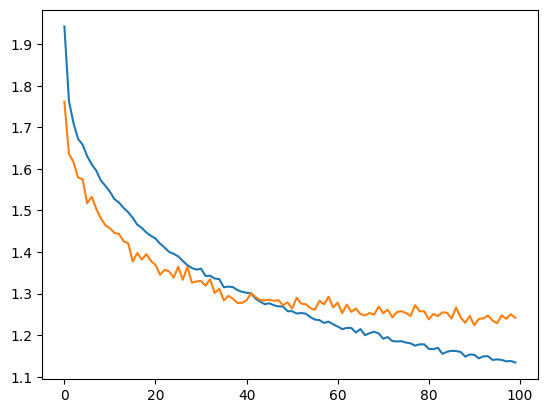

Accuracy: 0.6133


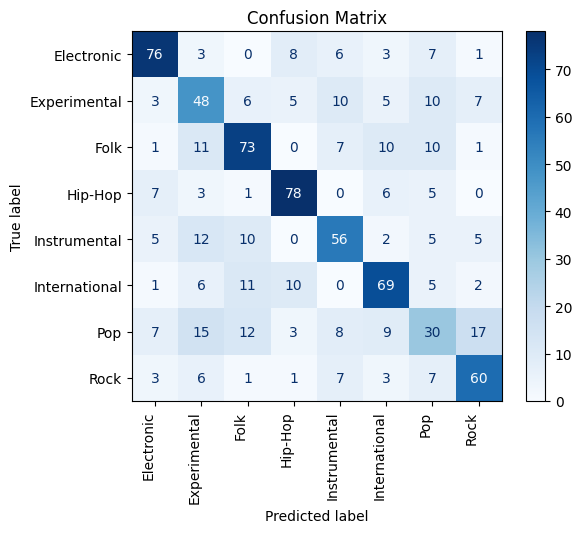

In [13]:
#torch.save(cnn.state_dict(), 'final_model_lin_specsplit.ckpt')
#cnn.load_state_dict(torch.load('best_model_lin_specsplit.ckpt'))

y_true = []
y_pred = []

for specs, labels in tqdm.tqdm(test_loader):
    with torch.no_grad():
        specs = split_tensor_into_eight(specs.to(device))
        logits = cnn(specs.to(device))

    logits = logits.unfold(0, 8, 8).permute([0, 2, 1]).mean(dim=1)
    loss = loss_fn(logits, labels.to(device))
    losses.append(loss.item())
    _, pred = torch.max(logits.data, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(pred.tolist())

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

l = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
#sns.heatmap(cm, annot=True, xticklabels=l, yticklabels=l, cmap='YlGnBu', fmt='d')
print('Accuracy: %.4f' % accuracy)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=l)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90, ha='right')
plt.title("Confusion Matrix")
plt.show()

np.save('y_true_model_2.npy', np.array(y_true))
np.save('y_pred_model_2.npy', np.array(y_pred))

In [ ]:
cnn.load_state_dict(torch.load('final_model_lin_specsplit.ckpt'))

n_epochs = 20
lr = 0.0001

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(cnn.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=20)

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    losses = []

    for specs, labels in tqdm.tqdm(train_loader):
        specs = split_tensor_into_eight(specs.to(device))
        logits = cnn(specs.to(device))
        loss = loss_fn(logits, torch.repeat_interleave(labels.to(device), 8))

        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())

    train_loss = np.mean(losses)
    train_losses.append(train_loss)
    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch + 1, n_epochs, train_loss))

    losses = []
    y_true = []
    y_pred = []

    y_true_full = []
    y_pred_full = []

    for specs, labels in tqdm.tqdm(valid_loader):
        with torch.no_grad():
            specs = split_tensor_into_eight(specs.to(device))
            logits = cnn(specs.to(device))

        _, pred_full = torch.max(logits.data, 1)

        y_true_full.extend(torch.repeat_interleave(labels, 8).tolist())
        y_pred_full.extend(pred_full.tolist())

        logits = logits.unfold(0, 8, 8).permute([0, 2, 1]).mean(dim=1)
        loss = loss_fn(logits, labels.to(device))
        losses.append(loss.item())
        _, pred = torch.max(logits.data, 1)

        y_true.extend(labels.tolist())
        y_pred.extend(pred.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    val_loss = np.mean(losses)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f, Valid accuracy full: %.4f, current LR: %f' % (epoch+1,
                                                                                                                 n_epochs,
                                                                                                                 val_loss,
                                                                                                                 accuracy,
                                                                                                                 accuracy_score(y_true_full, y_pred_full),
                                                                                                                 scheduler.get_last_lr()[-1]
                                                                                                                 ))

    if np.argmin(val_losses) == epoch:
        print('New best model found!')
        torch.save(cnn.state_dict(), 'best_model_lin_specsplit.ckpt')

torch.save(cnn.state_dict(), 'final_model_lin_specsplit.ckpt')
# Output here is broken?

<ipython-input-16-05785150090c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load('final_model_lin_specsplit.ckpt'))
100%|██████████| 175/175 [

Epoch: [1/20], Train loss: 1.1021


100%|██████████| 50/50 [00:10<00:00,  4.76it/s]


Epoch: [1/20], Valid loss: 1.2310, Valid accuracy: 0.5735, Valid accuracy full: 0.4916, current LR: 0.000100
New best model found!


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [2/20], Train loss: 1.0903


100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


Epoch: [2/20], Valid loss: 1.2188, Valid accuracy: 0.5754, Valid accuracy full: 0.4939, current LR: 0.000100
New best model found!


100%|██████████| 175/175 [01:26<00:00,  2.03it/s]


Epoch: [3/20], Train loss: 1.0840


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Epoch: [3/20], Valid loss: 1.2236, Valid accuracy: 0.5847, Valid accuracy full: 0.4892, current LR: 0.000100


100%|██████████| 175/175 [01:25<00:00,  2.04it/s]


Epoch: [4/20], Train loss: 1.0762


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


Epoch: [4/20], Valid loss: 1.2265, Valid accuracy: 0.5735, Valid accuracy full: 0.4889, current LR: 0.000100


100%|██████████| 175/175 [01:26<00:00,  2.02it/s]


Epoch: [5/20], Train loss: 1.0824


100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


Epoch: [5/20], Valid loss: 1.2164, Valid accuracy: 0.5916, Valid accuracy full: 0.4970, current LR: 0.000100
New best model found!


 53%|█████▎    | 93/175 [00:45<00:40,  2.04it/s]

100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Accuracy: 0.6446


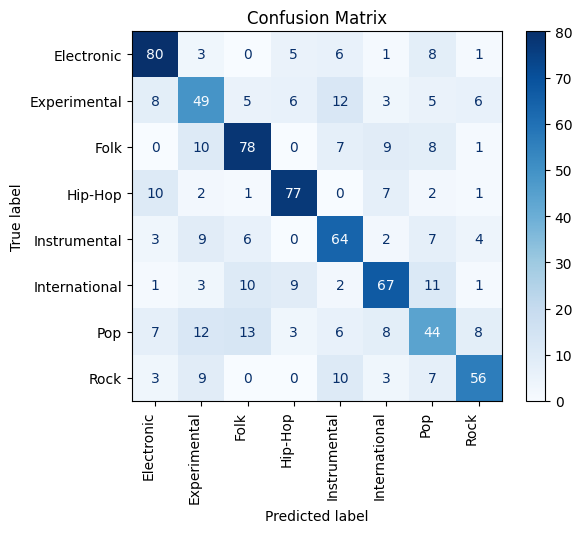

In [ ]:
y_true = []
y_pred = []

for specs, labels in tqdm.tqdm(test_loader):
    with torch.no_grad():
        specs = split_tensor_into_eight(specs.to(device))
        logits = cnn(specs.to(device))

    logits = logits.unfold(0, 8, 8).permute([0, 2, 1]).mean(dim=1)
    loss = loss_fn(logits, labels.to(device))
    losses.append(loss.item())
    _, pred = torch.max(logits.data, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(pred.tolist())


l = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print('Accuracy: %.4f' % accuracy)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=l)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90, ha='right')
plt.title("Confusion Matrix")
plt.show()

np.save('y_true_model_2.npy', np.array(y_true))
np.save('y_pred_model_2.npy', np.array(y_pred))

In [18]:
class Conv1d_layer(nn.Module):
    def __init__(self, out_c, kernel_size, pooling, dropout=0.1):
        super(Conv1d_layer, self).__init__()
        self.layer = nn.Sequential(
            nn.LazyConv1d(out_c, kernel_size, padding = kernel_size // 2),
            nn.BatchNorm1d(out_c),
            nn.ReLU(),
            nn.MaxPool1d(pooling, stride = pooling),
            nn.Dropout(dropout)
        )

    def forward(self, data):
        return self.layer(data)

class CNN_1DConv(nn.Module):
    def __init__(self, n_chan, kernel_size, n_genres):
        super(CNN_1DConv, self).__init__()

        self.convnet = nn.Sequential(
            nn.BatchNorm1d(n_chan),
            Conv1d_layer(n_chan * 3 // 4, kernel_size, pooling=4, dropout=0.25),
            Conv1d_layer(n_chan // 2, kernel_size, pooling=4, dropout=0.25),
            Conv1d_layer(n_chan // 2, kernel_size, pooling=4, dropout=0.25),
        )

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Dropout(),
            nn.LazyLinear(n_genres)
        )

    def forward(self, spec, hidden = None):
        return self.linear(self.convnet(spec))

In [19]:
cnn_conv = CNN_1DConv(n_chan = 128, kernel_size = 3, n_genres = 8).to(device)

# Send a sample to the net init all the lazy layers
t = cnn_conv(split_tensor_into_eight(train_spec).to(device))
del t

n_epochs = 100
lr = 0.001

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(cnn_conv.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=20)

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    losses = []

    for specs, labels in tqdm.tqdm(train_loader):
        specs = split_tensor_into_eight(specs.to(device))
        logits = cnn_conv(specs.to(device))
        loss = loss_fn(logits, torch.repeat_interleave(labels.to(device), 8))

        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())

    train_loss = np.mean(losses)
    train_losses.append(train_loss)
    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch + 1, n_epochs, train_loss))

    losses = []
    y_true = []
    y_pred = []

    y_true_full = []
    y_pred_full = []

    for specs, labels in tqdm.tqdm(valid_loader):
        with torch.no_grad():
            specs = split_tensor_into_eight(specs.to(device))
            logits = cnn_conv(specs.to(device))

        _, pred_full = torch.max(logits.data, 1)

        y_true_full.extend(torch.repeat_interleave(labels, 8).tolist())
        y_pred_full.extend(pred_full.tolist())

        logits = logits.unfold(0, 8, 8).permute([0, 2, 1]).mean(dim=1)
        loss = loss_fn(logits, labels.to(device))
        losses.append(loss.item())
        _, pred = torch.max(logits.data, 1)

        y_true.extend(labels.tolist())
        y_pred.extend(pred.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    val_loss = np.mean(losses)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f, Valid accuracy full: %.4f, current LR: %f' % (epoch+1,
                                                                                                                 n_epochs,
                                                                                                                 val_loss,
                                                                                                                 accuracy,
                                                                                                                 accuracy_score(y_true_full, y_pred_full),
                                                                                                                 scheduler.get_last_lr()[-1]
                                                                                                                 ))

    if np.argmin(val_losses) == epoch:
        print('New best model found!')
        torch.save(cnn_conv.state_dict(), 'best_model_lin_specsplit1d.ckpt')

torch.save(cnn_conv.state_dict(), 'final_model_lin_specsplit1d.ckpt')


100%|██████████| 175/175 [00:10<00:00, 15.97it/s]


Epoch: [1/100], Train loss: 1.8378


100%|██████████| 50/50 [00:02<00:00, 22.29it/s]


Epoch: [1/100], Valid loss: 1.6798, Valid accuracy: 0.3815, Valid accuracy full: 0.3473, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:10<00:00, 17.38it/s]


Epoch: [2/100], Train loss: 1.7150


100%|██████████| 50/50 [00:02<00:00, 21.25it/s]


Epoch: [2/100], Valid loss: 1.6070, Valid accuracy: 0.4153, Valid accuracy full: 0.3807, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 19.01it/s]


Epoch: [3/100], Train loss: 1.6785


100%|██████████| 50/50 [00:02<00:00, 19.24it/s]


Epoch: [3/100], Valid loss: 1.5446, Valid accuracy: 0.4403, Valid accuracy full: 0.3968, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:08<00:00, 20.37it/s]


Epoch: [4/100], Train loss: 1.6476


100%|██████████| 50/50 [00:02<00:00, 22.87it/s]


Epoch: [4/100], Valid loss: 1.5660, Valid accuracy: 0.4365, Valid accuracy full: 0.3974, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.24it/s]


Epoch: [5/100], Train loss: 1.6209


100%|██████████| 50/50 [00:02<00:00, 24.08it/s]


Epoch: [5/100], Valid loss: 1.5071, Valid accuracy: 0.4597, Valid accuracy full: 0.4165, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.76it/s]


Epoch: [6/100], Train loss: 1.5777


100%|██████████| 50/50 [00:02<00:00, 24.29it/s]


Epoch: [6/100], Valid loss: 1.4814, Valid accuracy: 0.4778, Valid accuracy full: 0.4296, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.57it/s]


Epoch: [7/100], Train loss: 1.5502


100%|██████████| 50/50 [00:02<00:00, 24.38it/s]


Epoch: [7/100], Valid loss: 1.4614, Valid accuracy: 0.4891, Valid accuracy full: 0.4450, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:08<00:00, 19.68it/s]


Epoch: [8/100], Train loss: 1.5227


100%|██████████| 50/50 [00:02<00:00, 18.66it/s]


Epoch: [8/100], Valid loss: 1.4229, Valid accuracy: 0.5097, Valid accuracy full: 0.4498, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 19.28it/s]


Epoch: [9/100], Train loss: 1.5048


100%|██████████| 50/50 [00:02<00:00, 20.07it/s]


Epoch: [9/100], Valid loss: 1.4112, Valid accuracy: 0.5078, Valid accuracy full: 0.4511, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 19.21it/s]


Epoch: [10/100], Train loss: 1.4887


100%|██████████| 50/50 [00:01<00:00, 25.21it/s]


Epoch: [10/100], Valid loss: 1.3795, Valid accuracy: 0.5172, Valid accuracy full: 0.4617, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 17.93it/s]


Epoch: [11/100], Train loss: 1.4676


100%|██████████| 50/50 [00:02<00:00, 24.50it/s]


Epoch: [11/100], Valid loss: 1.4277, Valid accuracy: 0.5009, Valid accuracy full: 0.4473, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.52it/s]


Epoch: [12/100], Train loss: 1.4621


100%|██████████| 50/50 [00:02<00:00, 23.91it/s]


Epoch: [12/100], Valid loss: 1.3807, Valid accuracy: 0.5197, Valid accuracy full: 0.4651, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.89it/s]


Epoch: [13/100], Train loss: 1.4463


100%|██████████| 50/50 [00:02<00:00, 24.25it/s]


Epoch: [13/100], Valid loss: 1.3399, Valid accuracy: 0.5347, Valid accuracy full: 0.4761, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:08<00:00, 20.15it/s]


Epoch: [14/100], Train loss: 1.4335


100%|██████████| 50/50 [00:02<00:00, 18.38it/s]


Epoch: [14/100], Valid loss: 1.3579, Valid accuracy: 0.5247, Valid accuracy full: 0.4740, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.56it/s]


Epoch: [15/100], Train loss: 1.4258


100%|██████████| 50/50 [00:02<00:00, 22.83it/s]


Epoch: [15/100], Valid loss: 1.3506, Valid accuracy: 0.5328, Valid accuracy full: 0.4796, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 17.90it/s]


Epoch: [16/100], Train loss: 1.4134


100%|██████████| 50/50 [00:02<00:00, 22.73it/s]


Epoch: [16/100], Valid loss: 1.3485, Valid accuracy: 0.5303, Valid accuracy full: 0.4797, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.36it/s]


Epoch: [17/100], Train loss: 1.3968


100%|██████████| 50/50 [00:02<00:00, 24.20it/s]


Epoch: [17/100], Valid loss: 1.3057, Valid accuracy: 0.5428, Valid accuracy full: 0.4812, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.50it/s]


Epoch: [18/100], Train loss: 1.3806


100%|██████████| 50/50 [00:01<00:00, 25.16it/s]


Epoch: [18/100], Valid loss: 1.3606, Valid accuracy: 0.5228, Valid accuracy full: 0.4710, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.36it/s]


Epoch: [19/100], Train loss: 1.3763


100%|██████████| 50/50 [00:02<00:00, 18.22it/s]


Epoch: [19/100], Valid loss: 1.3279, Valid accuracy: 0.5353, Valid accuracy full: 0.4766, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 20.36it/s]


Epoch: [20/100], Train loss: 1.3806


100%|██████████| 50/50 [00:02<00:00, 23.09it/s]


Epoch: [20/100], Valid loss: 1.3440, Valid accuracy: 0.5428, Valid accuracy full: 0.4756, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.05it/s]


Epoch: [21/100], Train loss: 1.3601


100%|██████████| 50/50 [00:02<00:00, 23.80it/s]


Epoch: [21/100], Valid loss: 1.3376, Valid accuracy: 0.5316, Valid accuracy full: 0.4783, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.55it/s]


Epoch: [22/100], Train loss: 1.3513


100%|██████████| 50/50 [00:02<00:00, 23.68it/s]


Epoch: [22/100], Valid loss: 1.3178, Valid accuracy: 0.5397, Valid accuracy full: 0.4834, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.64it/s]


Epoch: [23/100], Train loss: 1.3365


100%|██████████| 50/50 [00:01<00:00, 25.14it/s]


Epoch: [23/100], Valid loss: 1.2937, Valid accuracy: 0.5478, Valid accuracy full: 0.4909, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:08<00:00, 19.68it/s]


Epoch: [24/100], Train loss: 1.3224


100%|██████████| 50/50 [00:02<00:00, 19.84it/s]


Epoch: [24/100], Valid loss: 1.2729, Valid accuracy: 0.5604, Valid accuracy full: 0.4959, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:08<00:00, 19.68it/s]


Epoch: [25/100], Train loss: 1.3243


100%|██████████| 50/50 [00:02<00:00, 21.23it/s]


Epoch: [25/100], Valid loss: 1.2664, Valid accuracy: 0.5547, Valid accuracy full: 0.4996, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.99it/s]


Epoch: [26/100], Train loss: 1.3164


100%|██████████| 50/50 [00:02<00:00, 23.63it/s]


Epoch: [26/100], Valid loss: 1.2692, Valid accuracy: 0.5622, Valid accuracy full: 0.4952, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.60it/s]


Epoch: [27/100], Train loss: 1.3099


100%|██████████| 50/50 [00:02<00:00, 24.17it/s]


Epoch: [27/100], Valid loss: 1.2623, Valid accuracy: 0.5616, Valid accuracy full: 0.5033, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 17.56it/s]


Epoch: [28/100], Train loss: 1.3036


100%|██████████| 50/50 [00:02<00:00, 24.00it/s]


Epoch: [28/100], Valid loss: 1.2862, Valid accuracy: 0.5478, Valid accuracy full: 0.4893, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.24it/s]


Epoch: [29/100], Train loss: 1.3111


100%|██████████| 50/50 [00:02<00:00, 18.09it/s]


Epoch: [29/100], Valid loss: 1.2780, Valid accuracy: 0.5472, Valid accuracy full: 0.4937, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.80it/s]


Epoch: [30/100], Train loss: 1.2943


100%|██████████| 50/50 [00:02<00:00, 20.58it/s]


Epoch: [30/100], Valid loss: 1.2738, Valid accuracy: 0.5510, Valid accuracy full: 0.4854, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.95it/s]


Epoch: [31/100], Train loss: 1.2866


100%|██████████| 50/50 [00:02<00:00, 24.00it/s]


Epoch: [31/100], Valid loss: 1.2368, Valid accuracy: 0.5528, Valid accuracy full: 0.5063, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 17.70it/s]


Epoch: [32/100], Train loss: 1.2798


100%|██████████| 50/50 [00:02<00:00, 23.64it/s]


Epoch: [32/100], Valid loss: 1.2844, Valid accuracy: 0.5522, Valid accuracy full: 0.4876, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 17.92it/s]


Epoch: [33/100], Train loss: 1.2847


100%|██████████| 50/50 [00:02<00:00, 21.44it/s]


Epoch: [33/100], Valid loss: 1.2445, Valid accuracy: 0.5672, Valid accuracy full: 0.5031, current LR: 0.001000


100%|██████████| 175/175 [00:10<00:00, 17.01it/s]


Epoch: [34/100], Train loss: 1.2680


100%|██████████| 50/50 [00:02<00:00, 23.33it/s]


Epoch: [34/100], Valid loss: 1.2634, Valid accuracy: 0.5528, Valid accuracy full: 0.4981, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 19.79it/s]


Epoch: [35/100], Train loss: 1.2632


100%|██████████| 50/50 [00:02<00:00, 18.71it/s]


Epoch: [35/100], Valid loss: 1.2672, Valid accuracy: 0.5441, Valid accuracy full: 0.4919, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 20.04it/s]


Epoch: [36/100], Train loss: 1.2534


100%|██████████| 50/50 [00:02<00:00, 23.45it/s]


Epoch: [36/100], Valid loss: 1.2390, Valid accuracy: 0.5691, Valid accuracy full: 0.5078, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.94it/s]


Epoch: [37/100], Train loss: 1.2540


100%|██████████| 50/50 [00:02<00:00, 23.70it/s]


Epoch: [37/100], Valid loss: 1.2590, Valid accuracy: 0.5654, Valid accuracy full: 0.4959, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.44it/s]


Epoch: [38/100], Train loss: 1.2532


100%|██████████| 50/50 [00:02<00:00, 24.33it/s]


Epoch: [38/100], Valid loss: 1.2494, Valid accuracy: 0.5578, Valid accuracy full: 0.5041, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.64it/s]


Epoch: [39/100], Train loss: 1.2330


100%|██████████| 50/50 [00:02<00:00, 23.47it/s]


Epoch: [39/100], Valid loss: 1.2445, Valid accuracy: 0.5654, Valid accuracy full: 0.5020, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.73it/s]


Epoch: [40/100], Train loss: 1.2306


100%|██████████| 50/50 [00:02<00:00, 17.81it/s]


Epoch: [40/100], Valid loss: 1.2475, Valid accuracy: 0.5666, Valid accuracy full: 0.4974, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.96it/s]


Epoch: [41/100], Train loss: 1.2310


100%|██████████| 50/50 [00:02<00:00, 20.36it/s]


Epoch: [41/100], Valid loss: 1.2430, Valid accuracy: 0.5578, Valid accuracy full: 0.5016, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.10it/s]


Epoch: [42/100], Train loss: 1.2210


100%|██████████| 50/50 [00:02<00:00, 22.89it/s]


Epoch: [42/100], Valid loss: 1.2672, Valid accuracy: 0.5647, Valid accuracy full: 0.4978, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 17.86it/s]


Epoch: [43/100], Train loss: 1.2182


100%|██████████| 50/50 [00:02<00:00, 23.02it/s]


Epoch: [43/100], Valid loss: 1.2593, Valid accuracy: 0.5635, Valid accuracy full: 0.4938, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.23it/s]


Epoch: [44/100], Train loss: 1.2168


100%|██████████| 50/50 [00:02<00:00, 24.72it/s]


Epoch: [44/100], Valid loss: 1.2479, Valid accuracy: 0.5691, Valid accuracy full: 0.4991, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.90it/s]


Epoch: [45/100], Train loss: 1.2034


100%|██████████| 50/50 [00:02<00:00, 22.76it/s]


Epoch: [45/100], Valid loss: 1.2226, Valid accuracy: 0.5691, Valid accuracy full: 0.5106, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:08<00:00, 19.49it/s]


Epoch: [46/100], Train loss: 1.2111


100%|██████████| 50/50 [00:02<00:00, 18.92it/s]


Epoch: [46/100], Valid loss: 1.2266, Valid accuracy: 0.5766, Valid accuracy full: 0.5000, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 19.89it/s]


Epoch: [47/100], Train loss: 1.2037


100%|██████████| 50/50 [00:02<00:00, 24.45it/s]


Epoch: [47/100], Valid loss: 1.2324, Valid accuracy: 0.5660, Valid accuracy full: 0.5030, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.76it/s]


Epoch: [48/100], Train loss: 1.1998


100%|██████████| 50/50 [00:02<00:00, 24.10it/s]


Epoch: [48/100], Valid loss: 1.2543, Valid accuracy: 0.5610, Valid accuracy full: 0.4911, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.74it/s]


Epoch: [49/100], Train loss: 1.2005


100%|██████████| 50/50 [00:02<00:00, 23.97it/s]


Epoch: [49/100], Valid loss: 1.2870, Valid accuracy: 0.5416, Valid accuracy full: 0.4756, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 17.80it/s]


Epoch: [50/100], Train loss: 1.1866


100%|██████████| 50/50 [00:02<00:00, 22.56it/s]


Epoch: [50/100], Valid loss: 1.2220, Valid accuracy: 0.5760, Valid accuracy full: 0.5030, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 19.31it/s]


Epoch: [51/100], Train loss: 1.1849


100%|██████████| 50/50 [00:02<00:00, 18.78it/s]


Epoch: [51/100], Valid loss: 1.2239, Valid accuracy: 0.5797, Valid accuracy full: 0.5106, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.53it/s]


Epoch: [52/100], Train loss: 1.1834


100%|██████████| 50/50 [00:02<00:00, 22.38it/s]


Epoch: [52/100], Valid loss: 1.2187, Valid accuracy: 0.5672, Valid accuracy full: 0.5012, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 17.75it/s]


Epoch: [53/100], Train loss: 1.1767


100%|██████████| 50/50 [00:02<00:00, 22.65it/s]


Epoch: [53/100], Valid loss: 1.2282, Valid accuracy: 0.5722, Valid accuracy full: 0.5074, current LR: 0.001000


100%|██████████| 175/175 [00:10<00:00, 17.16it/s]


Epoch: [54/100], Train loss: 1.1732


100%|██████████| 50/50 [00:02<00:00, 22.65it/s]


Epoch: [54/100], Valid loss: 1.2173, Valid accuracy: 0.5666, Valid accuracy full: 0.5002, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.15it/s]


Epoch: [55/100], Train loss: 1.1760


100%|██████████| 50/50 [00:02<00:00, 23.56it/s]


Epoch: [55/100], Valid loss: 1.2224, Valid accuracy: 0.5691, Valid accuracy full: 0.5043, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.29it/s]


Epoch: [56/100], Train loss: 1.1746


100%|██████████| 50/50 [00:02<00:00, 19.48it/s]


Epoch: [56/100], Valid loss: 1.2032, Valid accuracy: 0.5841, Valid accuracy full: 0.5178, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.82it/s]


Epoch: [57/100], Train loss: 1.1630


100%|██████████| 50/50 [00:02<00:00, 18.37it/s]


Epoch: [57/100], Valid loss: 1.2342, Valid accuracy: 0.5679, Valid accuracy full: 0.5002, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.30it/s]


Epoch: [58/100], Train loss: 1.1558


100%|██████████| 50/50 [00:02<00:00, 22.62it/s]


Epoch: [58/100], Valid loss: 1.2013, Valid accuracy: 0.5747, Valid accuracy full: 0.5087, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.47it/s]


Epoch: [59/100], Train loss: 1.1498


100%|██████████| 50/50 [00:01<00:00, 25.06it/s]


Epoch: [59/100], Valid loss: 1.2032, Valid accuracy: 0.5785, Valid accuracy full: 0.5076, current LR: 0.001000


100%|██████████| 175/175 [00:10<00:00, 17.44it/s]


Epoch: [60/100], Train loss: 1.1559


100%|██████████| 50/50 [00:02<00:00, 22.79it/s]


Epoch: [60/100], Valid loss: 1.2301, Valid accuracy: 0.5754, Valid accuracy full: 0.5044, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.63it/s]


Epoch: [61/100], Train loss: 1.1538


100%|██████████| 50/50 [00:02<00:00, 24.41it/s]


Epoch: [61/100], Valid loss: 1.2182, Valid accuracy: 0.5735, Valid accuracy full: 0.5084, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.15it/s]


Epoch: [62/100], Train loss: 1.1448


100%|██████████| 50/50 [00:02<00:00, 17.29it/s]


Epoch: [62/100], Valid loss: 1.2131, Valid accuracy: 0.5766, Valid accuracy full: 0.5068, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.15it/s]


Epoch: [63/100], Train loss: 1.1379


100%|██████████| 50/50 [00:02<00:00, 19.46it/s]


Epoch: [63/100], Valid loss: 1.2013, Valid accuracy: 0.5829, Valid accuracy full: 0.5188, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.71it/s]


Epoch: [64/100], Train loss: 1.1366


100%|██████████| 50/50 [00:02<00:00, 22.29it/s]


Epoch: [64/100], Valid loss: 1.2160, Valid accuracy: 0.5791, Valid accuracy full: 0.5081, current LR: 0.001000


100%|██████████| 175/175 [00:10<00:00, 17.42it/s]


Epoch: [65/100], Train loss: 1.1305


100%|██████████| 50/50 [00:02<00:00, 23.76it/s]


Epoch: [65/100], Valid loss: 1.2205, Valid accuracy: 0.5760, Valid accuracy full: 0.5045, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.42it/s]


Epoch: [66/100], Train loss: 1.1332


100%|██████████| 50/50 [00:02<00:00, 24.83it/s]


Epoch: [66/100], Valid loss: 1.2001, Valid accuracy: 0.5866, Valid accuracy full: 0.5142, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:10<00:00, 17.25it/s]


Epoch: [67/100], Train loss: 1.1343


100%|██████████| 50/50 [00:02<00:00, 23.37it/s]


Epoch: [67/100], Valid loss: 1.1955, Valid accuracy: 0.5779, Valid accuracy full: 0.5147, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.17it/s]


Epoch: [68/100], Train loss: 1.1269


100%|██████████| 50/50 [00:02<00:00, 18.42it/s]


Epoch: [68/100], Valid loss: 1.2061, Valid accuracy: 0.5847, Valid accuracy full: 0.5120, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 20.68it/s]


Epoch: [69/100], Train loss: 1.1256


100%|██████████| 50/50 [00:02<00:00, 19.97it/s]


Epoch: [69/100], Valid loss: 1.2064, Valid accuracy: 0.5660, Valid accuracy full: 0.5056, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.12it/s]


Epoch: [70/100], Train loss: 1.1188


100%|██████████| 50/50 [00:02<00:00, 24.79it/s]


Epoch: [70/100], Valid loss: 1.2024, Valid accuracy: 0.5779, Valid accuracy full: 0.5055, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 17.72it/s]


Epoch: [71/100], Train loss: 1.1224


100%|██████████| 50/50 [00:02<00:00, 22.87it/s]


Epoch: [71/100], Valid loss: 1.1990, Valid accuracy: 0.5797, Valid accuracy full: 0.5113, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 17.77it/s]


Epoch: [72/100], Train loss: 1.1095


100%|██████████| 50/50 [00:02<00:00, 24.02it/s]


Epoch: [72/100], Valid loss: 1.2017, Valid accuracy: 0.5847, Valid accuracy full: 0.5081, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.12it/s]


Epoch: [73/100], Train loss: 1.1139


100%|██████████| 50/50 [00:02<00:00, 20.05it/s]


Epoch: [73/100], Valid loss: 1.2171, Valid accuracy: 0.5735, Valid accuracy full: 0.4986, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 20.09it/s]


Epoch: [74/100], Train loss: 1.1115


100%|██████████| 50/50 [00:02<00:00, 23.15it/s]


Epoch: [74/100], Valid loss: 1.2144, Valid accuracy: 0.5729, Valid accuracy full: 0.5049, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.63it/s]


Epoch: [75/100], Train loss: 1.0996


100%|██████████| 50/50 [00:02<00:00, 24.94it/s]


Epoch: [75/100], Valid loss: 1.2202, Valid accuracy: 0.5716, Valid accuracy full: 0.4996, current LR: 0.001000


100%|██████████| 175/175 [00:10<00:00, 17.45it/s]


Epoch: [76/100], Train loss: 1.1074


100%|██████████| 50/50 [00:02<00:00, 21.87it/s]


Epoch: [76/100], Valid loss: 1.2095, Valid accuracy: 0.5779, Valid accuracy full: 0.5046, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.48it/s]


Epoch: [77/100], Train loss: 1.1069


100%|██████████| 50/50 [00:02<00:00, 24.61it/s]


Epoch: [77/100], Valid loss: 1.2198, Valid accuracy: 0.5716, Valid accuracy full: 0.5022, current LR: 0.001000


100%|██████████| 175/175 [00:10<00:00, 17.49it/s]


Epoch: [78/100], Train loss: 1.1094


100%|██████████| 50/50 [00:02<00:00, 21.65it/s]


Epoch: [78/100], Valid loss: 1.2004, Valid accuracy: 0.5829, Valid accuracy full: 0.5076, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 20.30it/s]


Epoch: [79/100], Train loss: 1.0933


100%|██████████| 50/50 [00:02<00:00, 18.24it/s]


Epoch: [79/100], Valid loss: 1.2097, Valid accuracy: 0.5754, Valid accuracy full: 0.5121, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.15it/s]


Epoch: [80/100], Train loss: 1.1027


100%|██████████| 50/50 [00:02<00:00, 21.00it/s]


Epoch: [80/100], Valid loss: 1.2104, Valid accuracy: 0.5679, Valid accuracy full: 0.5059, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.91it/s]


Epoch: [81/100], Train loss: 1.0825


100%|██████████| 50/50 [00:02<00:00, 23.76it/s]


Epoch: [81/100], Valid loss: 1.1891, Valid accuracy: 0.5904, Valid accuracy full: 0.5116, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:10<00:00, 17.33it/s]


Epoch: [82/100], Train loss: 1.0883


100%|██████████| 50/50 [00:02<00:00, 22.97it/s]


Epoch: [82/100], Valid loss: 1.2107, Valid accuracy: 0.5722, Valid accuracy full: 0.4998, current LR: 0.001000


100%|██████████| 175/175 [00:10<00:00, 17.41it/s]


Epoch: [83/100], Train loss: 1.0899


100%|██████████| 50/50 [00:02<00:00, 24.02it/s]


Epoch: [83/100], Valid loss: 1.1873, Valid accuracy: 0.5916, Valid accuracy full: 0.5146, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 19.12it/s]


Epoch: [84/100], Train loss: 1.0895


100%|██████████| 50/50 [00:02<00:00, 19.68it/s]


Epoch: [84/100], Valid loss: 1.2146, Valid accuracy: 0.5804, Valid accuracy full: 0.5094, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 20.33it/s]


Epoch: [85/100], Train loss: 1.0917


100%|██████████| 50/50 [00:02<00:00, 21.18it/s]


Epoch: [85/100], Valid loss: 1.2174, Valid accuracy: 0.5666, Valid accuracy full: 0.4998, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.24it/s]


Epoch: [86/100], Train loss: 1.0699


100%|██████████| 50/50 [00:02<00:00, 22.39it/s]


Epoch: [86/100], Valid loss: 1.2088, Valid accuracy: 0.5816, Valid accuracy full: 0.5032, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 17.54it/s]


Epoch: [87/100], Train loss: 1.0730


100%|██████████| 50/50 [00:02<00:00, 22.89it/s]


Epoch: [87/100], Valid loss: 1.1915, Valid accuracy: 0.5797, Valid accuracy full: 0.5130, current LR: 0.001000


100%|██████████| 175/175 [00:10<00:00, 17.35it/s]


Epoch: [88/100], Train loss: 1.0757


100%|██████████| 50/50 [00:02<00:00, 24.15it/s]


Epoch: [88/100], Valid loss: 1.1958, Valid accuracy: 0.5847, Valid accuracy full: 0.5096, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.67it/s]


Epoch: [89/100], Train loss: 1.0743


100%|██████████| 50/50 [00:01<00:00, 25.05it/s]


Epoch: [89/100], Valid loss: 1.2038, Valid accuracy: 0.5729, Valid accuracy full: 0.5002, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.82it/s]


Epoch: [90/100], Train loss: 1.0747


100%|██████████| 50/50 [00:02<00:00, 18.68it/s]


Epoch: [90/100], Valid loss: 1.2022, Valid accuracy: 0.5854, Valid accuracy full: 0.5141, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 20.29it/s]


Epoch: [91/100], Train loss: 1.0646


100%|██████████| 50/50 [00:02<00:00, 20.68it/s]


Epoch: [91/100], Valid loss: 1.1765, Valid accuracy: 0.5897, Valid accuracy full: 0.5152, current LR: 0.001000
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.90it/s]


Epoch: [92/100], Train loss: 1.0750


100%|██████████| 50/50 [00:01<00:00, 25.13it/s]


Epoch: [92/100], Valid loss: 1.1924, Valid accuracy: 0.5747, Valid accuracy full: 0.5059, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.52it/s]


Epoch: [93/100], Train loss: 1.0679


100%|██████████| 50/50 [00:03<00:00, 16.50it/s]


Epoch: [93/100], Valid loss: 1.2055, Valid accuracy: 0.5866, Valid accuracy full: 0.5067, current LR: 0.001000


100%|██████████| 175/175 [00:10<00:00, 16.75it/s]


Epoch: [94/100], Train loss: 1.0576


100%|██████████| 50/50 [00:02<00:00, 23.32it/s]


Epoch: [94/100], Valid loss: 1.1951, Valid accuracy: 0.5829, Valid accuracy full: 0.5053, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 18.49it/s]


Epoch: [95/100], Train loss: 1.0682


100%|██████████| 50/50 [00:02<00:00, 22.01it/s]


Epoch: [95/100], Valid loss: 1.1966, Valid accuracy: 0.5816, Valid accuracy full: 0.5034, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.33it/s]


Epoch: [96/100], Train loss: 1.0605


100%|██████████| 50/50 [00:02<00:00, 18.02it/s]


Epoch: [96/100], Valid loss: 1.1877, Valid accuracy: 0.5822, Valid accuracy full: 0.5132, current LR: 0.001000


100%|██████████| 175/175 [00:08<00:00, 19.46it/s]


Epoch: [97/100], Train loss: 1.0528


100%|██████████| 50/50 [00:02<00:00, 21.58it/s]


Epoch: [97/100], Valid loss: 1.1911, Valid accuracy: 0.5997, Valid accuracy full: 0.5135, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 19.05it/s]


Epoch: [98/100], Train loss: 1.0655


100%|██████████| 50/50 [00:02<00:00, 22.95it/s]


Epoch: [98/100], Valid loss: 1.2034, Valid accuracy: 0.5822, Valid accuracy full: 0.5001, current LR: 0.001000


100%|██████████| 175/175 [00:10<00:00, 17.26it/s]


Epoch: [99/100], Train loss: 1.0528


100%|██████████| 50/50 [00:02<00:00, 22.06it/s]


Epoch: [99/100], Valid loss: 1.2055, Valid accuracy: 0.5829, Valid accuracy full: 0.5092, current LR: 0.001000


100%|██████████| 175/175 [00:09<00:00, 17.82it/s]


Epoch: [100/100], Train loss: 1.0557


100%|██████████| 50/50 [00:02<00:00, 22.51it/s]

Epoch: [100/100], Valid loss: 1.1902, Valid accuracy: 0.5872, Valid accuracy full: 0.5102, current LR: 0.001000


100%|██████████| 25/25 [00:00<00:00, 25.02it/s]


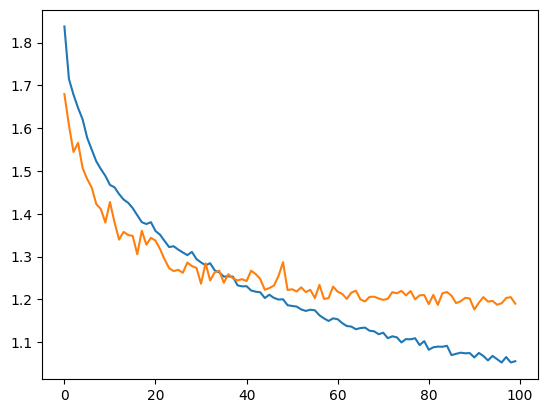

Accuracy: 0.6245


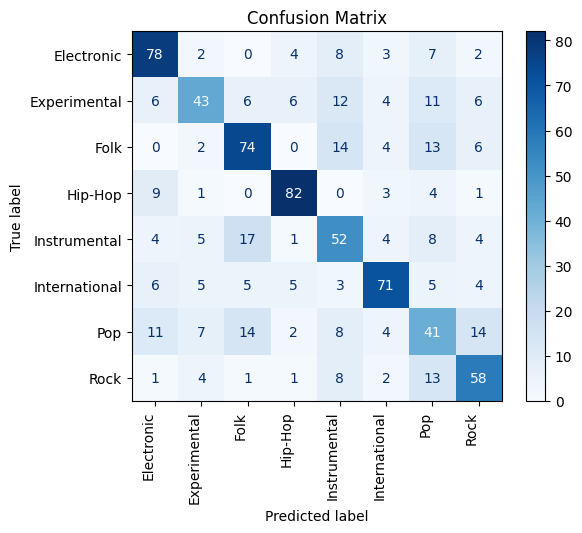

In [22]:
#torch.save(cnn_conv.state_dict(), 'final_model_lin_specsplit1d.ckpt')
#cnn_conv.load_state_dict(torch.load('best_model_lin_specsplit1d.ckpt'))

y_true = []
y_pred = []

for specs, labels in tqdm.tqdm(test_loader):
    with torch.no_grad():
        specs = split_tensor_into_eight(specs.to(device))
        logits = cnn_conv(specs.to(device))

    logits = logits.unfold(0, 8, 8).permute([0, 2, 1]).mean(dim=1)

    _, pred = torch.max(logits.data, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(pred.tolist())

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

l = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
#sns.heatmap(cm, annot=True, xticklabels=l, yticklabels=l, cmap='YlGnBu', fmt='d')
print('Accuracy: %.4f' % accuracy)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=l)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90, ha='right')
plt.title("Confusion Matrix")
plt.show()

np.save('y_true_model_3.npy', np.array(y_true))
np.save('y_pred_model_3.npy', np.array(y_pred))

In [ ]:
cnn_conv.load_state_dict(torch.load('final_model_lin_specsplit1d.ckpt'))

n_epochs = 20
lr = 0.0001

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(cnn_conv.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=20)

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    losses = []

    for specs, labels in tqdm.tqdm(train_loader):
        specs = split_tensor_into_eight(specs.to(device))
        logits = cnn_conv(specs.to(device))
        loss = loss_fn(logits, torch.repeat_interleave(labels.to(device), 8))

        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())

    train_loss = np.mean(losses)
    train_losses.append(train_loss)
    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch + 1, n_epochs, train_loss))

    losses = []
    y_true = []
    y_pred = []

    y_true_full = []
    y_pred_full = []

    for specs, labels in tqdm.tqdm(valid_loader):
        with torch.no_grad():
            specs = split_tensor_into_eight(specs.to(device))
            logits = cnn_conv(specs.to(device))

        _, pred_full = torch.max(logits.data, 1)

        y_true_full.extend(torch.repeat_interleave(labels, 8).tolist())
        y_pred_full.extend(pred_full.tolist())

        logits = logits.unfold(0, 8, 8).permute([0, 2, 1]).mean(dim=1)
        loss = loss_fn(logits, labels.to(device))
        losses.append(loss.item())
        _, pred = torch.max(logits.data, 1)

        y_true.extend(labels.tolist())
        y_pred.extend(pred.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    val_loss = np.mean(losses)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f, Valid accuracy full: %.4f, current LR: %f' % (epoch+1,
                                                                                                                 n_epochs,
                                                                                                                 val_loss,
                                                                                                                 accuracy,
                                                                                                                 accuracy_score(y_true_full, y_pred_full),
                                                                                                                 scheduler.get_last_lr()[-1]
                                                                                                                 ))

    if np.argmin(val_losses) == epoch:
        print('New best model found!')
        torch.save(cnn_conv.state_dict(), 'best_model_lin_specsplit1d.ckpt')

torch.save(cnn_conv.state_dict(), 'final_model_lin_specsplit1d.ckpt')


<ipython-input-25-275076041ea4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_conv.load_state_dict(torch.load('final_model_lin_specsplit1d.ckpt'))
100%|██████████| 17

Epoch: [1/20], Train loss: 1.0003


100%|██████████| 50/50 [00:02<00:00, 22.29it/s]


Epoch: [1/20], Valid loss: 1.1674, Valid accuracy: 0.5972, Valid accuracy full: 0.5169, current LR: 0.000100
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.98it/s]


Epoch: [2/20], Train loss: 0.9859


100%|██████████| 50/50 [00:01<00:00, 25.26it/s]


Epoch: [2/20], Valid loss: 1.1746, Valid accuracy: 0.5960, Valid accuracy full: 0.5191, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.68it/s]


Epoch: [3/20], Train loss: 0.9797


100%|██████████| 50/50 [00:02<00:00, 24.79it/s]


Epoch: [3/20], Valid loss: 1.1632, Valid accuracy: 0.5991, Valid accuracy full: 0.5153, current LR: 0.000100
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.82it/s]


Epoch: [4/20], Train loss: 0.9817


100%|██████████| 50/50 [00:02<00:00, 24.03it/s]


Epoch: [4/20], Valid loss: 1.1626, Valid accuracy: 0.6023, Valid accuracy full: 0.5227, current LR: 0.000100
New best model found!


100%|██████████| 175/175 [00:08<00:00, 19.52it/s]


Epoch: [5/20], Train loss: 0.9790


100%|██████████| 50/50 [00:02<00:00, 20.25it/s]


Epoch: [5/20], Valid loss: 1.1626, Valid accuracy: 0.6066, Valid accuracy full: 0.5160, current LR: 0.000100


100%|██████████| 175/175 [00:12<00:00, 13.90it/s]


Epoch: [6/20], Train loss: 0.9783


100%|██████████| 50/50 [00:04<00:00, 10.45it/s]


Epoch: [6/20], Valid loss: 1.1758, Valid accuracy: 0.6054, Valid accuracy full: 0.5160, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.57it/s]


Epoch: [7/20], Train loss: 0.9723


100%|██████████| 50/50 [00:02<00:00, 19.69it/s]


Epoch: [7/20], Valid loss: 1.1670, Valid accuracy: 0.5991, Valid accuracy full: 0.5190, current LR: 0.000100


100%|██████████| 175/175 [00:08<00:00, 20.60it/s]


Epoch: [8/20], Train loss: 0.9750


100%|██████████| 50/50 [00:02<00:00, 22.42it/s]


Epoch: [8/20], Valid loss: 1.1672, Valid accuracy: 0.5972, Valid accuracy full: 0.5144, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.95it/s]


Epoch: [9/20], Train loss: 0.9688


100%|██████████| 50/50 [00:02<00:00, 23.94it/s]


Epoch: [9/20], Valid loss: 1.1644, Valid accuracy: 0.5985, Valid accuracy full: 0.5090, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.60it/s]


Epoch: [10/20], Train loss: 0.9739


100%|██████████| 50/50 [00:02<00:00, 23.41it/s]


Epoch: [10/20], Valid loss: 1.1605, Valid accuracy: 0.5922, Valid accuracy full: 0.5157, current LR: 0.000100
New best model found!


100%|██████████| 175/175 [00:09<00:00, 18.79it/s]


Epoch: [11/20], Train loss: 0.9802


100%|██████████| 50/50 [00:02<00:00, 24.69it/s]


Epoch: [11/20], Valid loss: 1.1567, Valid accuracy: 0.5960, Valid accuracy full: 0.5159, current LR: 0.000100
New best model found!


100%|██████████| 175/175 [00:09<00:00, 19.39it/s]


Epoch: [12/20], Train loss: 0.9640


100%|██████████| 50/50 [00:02<00:00, 19.80it/s]


Epoch: [12/20], Valid loss: 1.1661, Valid accuracy: 0.6035, Valid accuracy full: 0.5170, current LR: 0.000100


100%|██████████| 175/175 [00:08<00:00, 20.19it/s]


Epoch: [13/20], Train loss: 0.9693


100%|██████████| 50/50 [00:03<00:00, 14.08it/s]


Epoch: [13/20], Valid loss: 1.1665, Valid accuracy: 0.5916, Valid accuracy full: 0.5175, current LR: 0.000100


100%|██████████| 175/175 [00:08<00:00, 19.56it/s]


Epoch: [14/20], Train loss: 0.9732


100%|██████████| 50/50 [00:02<00:00, 19.30it/s]


Epoch: [14/20], Valid loss: 1.1606, Valid accuracy: 0.6010, Valid accuracy full: 0.5181, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.65it/s]


Epoch: [15/20], Train loss: 0.9686


100%|██████████| 50/50 [00:01<00:00, 25.31it/s]


Epoch: [15/20], Valid loss: 1.1724, Valid accuracy: 0.5947, Valid accuracy full: 0.5198, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.68it/s]


Epoch: [16/20], Train loss: 0.9753


100%|██████████| 50/50 [00:02<00:00, 23.91it/s]


Epoch: [16/20], Valid loss: 1.1726, Valid accuracy: 0.5929, Valid accuracy full: 0.5145, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.83it/s]


Epoch: [17/20], Train loss: 0.9691


100%|██████████| 50/50 [00:02<00:00, 22.73it/s]


Epoch: [17/20], Valid loss: 1.1754, Valid accuracy: 0.6035, Valid accuracy full: 0.5120, current LR: 0.000100


100%|██████████| 175/175 [00:08<00:00, 20.49it/s]


Epoch: [18/20], Train loss: 0.9645


100%|██████████| 50/50 [00:02<00:00, 18.44it/s]


Epoch: [18/20], Valid loss: 1.1604, Valid accuracy: 0.6016, Valid accuracy full: 0.5200, current LR: 0.000100


100%|██████████| 175/175 [00:08<00:00, 19.64it/s]


Epoch: [19/20], Train loss: 0.9708


100%|██████████| 50/50 [00:02<00:00, 23.61it/s]


Epoch: [19/20], Valid loss: 1.1689, Valid accuracy: 0.5979, Valid accuracy full: 0.5170, current LR: 0.000100


100%|██████████| 175/175 [00:09<00:00, 18.58it/s]


Epoch: [20/20], Train loss: 0.9643


100%|██████████| 50/50 [00:02<00:00, 23.46it/s]

Epoch: [20/20], Valid loss: 1.1741, Valid accuracy: 0.6029, Valid accuracy full: 0.5158, current LR: 0.000100


100%|██████████| 25/25 [00:01<00:00, 24.46it/s]


Accuracy: 0.6421


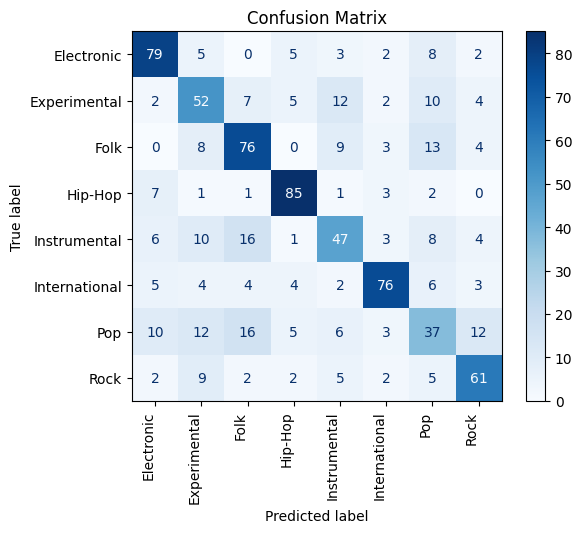

In [ ]:
y_true = []
y_pred = []

for specs, labels in tqdm.tqdm(test_loader):
    with torch.no_grad():
        specs = split_tensor_into_eight(specs.to(device))
        logits = cnn_conv(specs.to(device))

    logits = logits.unfold(0, 8, 8).permute([0, 2, 1]).mean(dim=1)

    _, pred = torch.max(logits.data, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(pred.tolist())


l = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
#sns.heatmap(cm, annot=True, xticklabels=l, yticklabels=l, cmap='YlGnBu', fmt='d')
print('Accuracy: %.4f' % accuracy)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=l)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90, ha='right')
plt.title("Confusion Matrix")
plt.show()

np.save('y_true_model_3.npy', np.array(y_true))
np.save('y_pred_model_3.npy', np.array(y_pred))